In [661]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [6]:
a = np.array([1, 2, 3]).astype('float32')
a = tf.constant(a)

In [780]:
help(make_classification)

Help on function make_classification in module sklearn.datasets._samples_generator:

make_classification(n_samples=100, n_features=20, n_informative=2, n_redundant=2, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
    Generate a random n-class classification problem.
    
    This initially creates clusters of points normally distributed (std=1)
    about vertices of an ``n_informative``-dimensional hypercube with sides of
    length ``2*class_sep`` and assigns an equal number of clusters to each
    class. It introduces interdependence between these features and adds
    various types of further noise to the data.
    
    Without shuffling, ``X`` horizontally stacks features in the following
    order: the primary ``n_informative`` features, followed by ``n_redundant``
    linear combinations of the informative features, followed by ``n_repeated``
    duplicates, drawn

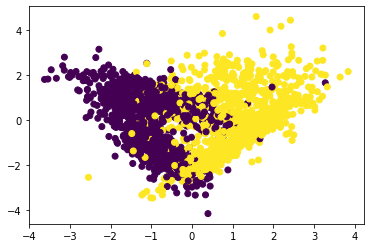

In [837]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import roc_auc_score
%matplotlib inline

from sklearn.datasets import make_classification
X, y = make_classification(n_samples= 2000, n_features = 2, n_informative = 2,n_redundant = 0, n_classes = 2)
plt.scatter(X[:,0], X[:,1], c=y);

In [845]:
y = np.array([y,y]).T.reshape((2000, 2, 1))

array([[[0],
        [0]],

       [[0],
        [0]],

       [[1],
        [1]],

       ...,

       [[0],
        [0]],

       [[0],
        [0]],

       [[0],
        [0]]])

In [877]:
def get_model():
    learning_rate = 1.0
    input_layer = tf.keras.Input((2,))
    hidden = tf.keras.layers.Dense(100, activation = 'relu')(input_layer)
    hidden = tf.keras.layers.Dense(100, activation = 'relu')(hidden)
    hidden = tf.keras.layers.Dense(100, activation = 'relu')(hidden)
    activations = tf.keras.layers.Dense(3, activation = 'sigmoid')(hidden)
    # predictions = tf.sigmoid(activations)
#     activations = tf.reshape(activations, [2,1])
    activations = tf.expand_dims(activations, 2)
    model = tf.keras.Model(input_layer, activations)
    return model

In [878]:
model = get_model()
model.summary()

Model: "model_165"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_170 (InputLayer)       [(None, 2)]               0         
_________________________________________________________________
dense_483 (Dense)            (None, 100)               300       
_________________________________________________________________
dense_484 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_485 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_486 (Dense)            (None, 3)                 303       
_________________________________________________________________
tf.expand_dims_20 (TFOpLambd (None, 3, 1)              0         
Total params: 20,803
Trainable params: 20,803
Non-trainable params: 0
_____________________________________________________

In [895]:
def make_experiment(n_point, data = None, batch_size = 32):
    if data is not None:
        X, y = data
    else:
        X, y = make_classification(n_samples= n_point, n_features = 2, n_informative = 2,n_redundant = 0, n_classes = 2)
    plt.figure(0, figsize = (10, 10))
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.title('whole data')
    
    y = np.array([y,y, y]).T.reshape((n_point, 3, 1))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#     y = y.reshape(-1,1)
#     y_train = y_train.reshape(-1,1)
#     y_test = y_test.reshape(-1,1)
    print(y_train.shape)
    l_train = len(X_train)//batch_size * batch_size
    l_test = len(X_test)//batch_size * batch_size

    X_train = X_train[:l_train]
    X_test = X_test[:l_test]
    y_train = y_train[:l_train]
    y_test = y_test[:l_test]
    
    ## AUC
    model = get_model()
    optimizer = tf.keras.optimizers.SGD(0.1)
    metric = []
#     print(model(X_train))
    model.compile(optimizer = optimizer,
             loss = loss_auc,
#              loss = 'binary_crossentropy',
             metrics = metric)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose = 0,min_delta=0.005,
                              patience=6, min_lr=0.000001)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=16, verbose=0, mode='auto',baseline=None, restore_best_weights=True)
#     print(X_train)
#     print(model(X_train))
    model.fit(X_train, y_train, batch_size = batch_size, epochs = 200, validation_data = (X_test, y_test), callbacks = [reduce_lr,early_stop], verbose = 0)
    
    pred = model.predict(X_test)
    plt.figure(1, figsize = (10, 10))
    plt.scatter(X_test[:,0], X_test[:,1], c=pred[:,0, 0]);
    plt.title('pred auc')
#     plt.figure(2, figsize = (10, 10))
#     plt.scatter(X_test[:,0], X_test[:,1], c=y_test[:,0, 0]);
#     plt.title('true')
    auc_auc = roc_auc_score(y_test[:,0], pred[:,0])
    print('auc_score : '+str(auc_auc))
    
    ## BIN
    model = get_model()
    optimizer = tf.keras.optimizers.SGD(0.1)
    metric = []
    model.compile(optimizer = optimizer,
#              loss = loss_auc,
             loss = 'binary_crossentropy',
             metrics = metric)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose = 0,min_delta=0.005,
                              patience=6, min_lr=0.000001)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=16, verbose=0, mode='auto',baseline=None, restore_best_weights=True)

    
    model.fit(X_train, y_train, batch_size = batch_size, epochs = 200, validation_data = (X_test, y_test), callbacks = [reduce_lr, early_stop], verbose = 0)
    pred = model.predict(X_test)
#     print(model(X_test))
#     plt.figure(3, figsize = (10, 10))
#     plt.scatter(X_test[:,0], X_test[:,1], c=pred[:,0]);
#     plt.title('pred bin')
    bin_auc = roc_auc_score(y_test[:,0], pred[:,0])
    print('bin_score : '+str(bin_auc))
    return auc_auc, bin_auc

In [896]:
temperature = 10
batch_size = 64
seq_len = 3
def loss_auc(true, pred):
    pred = tf.reshape(pred, [-1,1])
    true = tf.reshape(true, [-1,1])
    
    pred = tf.repeat(pred, batch_size*seq_len, axis = -1)
    diff1 = tf.math.exp(- temperature * (pred - tf.transpose(pred)))
    true = tf.repeat(true, batch_size*seq_len, axis = -1)
    zero_un_comp = tf.cast(tf.math.maximum(true - tf.transpose(true), 0), dtype = diff1.dtype)
    diff1 *= zero_un_comp
    return tf.math.reduce_sum(diff1)/tf.math.reduce_sum(zero_un_comp)

(1340, 3, 1)
auc_score : 0.9518812713114674
bin_score : 0.9460679426678782


(0.9518812713114674, 0.9460679426678782)

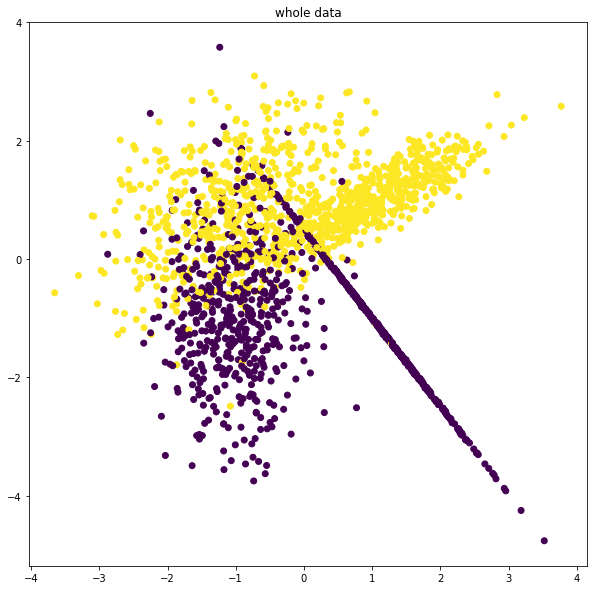

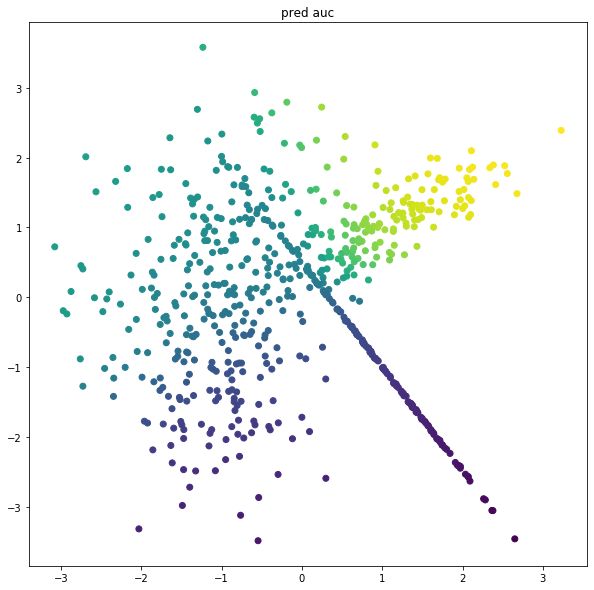

In [897]:
make_experiment(2000, batch_size = batch_size)

In [871]:
a = np.random.uniform(0,1, size = (32, 128, 1)).astype('float32')
a = tf.constant(a)

In [872]:
tf.reshape(a, [-1, 1])

<tf.Tensor: shape=(4096, 1), dtype=float32, numpy=
array([[0.05867933],
       [0.4507033 ],
       [0.37482762],
       ...,
       [0.22420171],
       [0.71370506],
       [0.12835191]], dtype=float32)>

In [768]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from copy import deepcopy
import seaborn as sns
import gc
import datetime
from wordcloud import WordCloud
import urllib
import cv2
import bs4
import requests
from io import BytesIO



pd.set_option('display.max_columns', 50)

import _pickle as pickle
def save(file,name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'wb')
    else:
        outfile = open(name+'.pickle', 'wb')
    pickle.dump(file, outfile)
    outfile.close
    
def load(name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'rb')
    else:
        outfile = open(name+'.pickle', 'rb')
    file = pickle.load(outfile)
    outfile.close
    return file

def palette(vect):
    return sns.color_palette("mako", n_colors = len(vect))

sns.set_palette("mako")

- Pie chart : L'O vs. competiton

## Parameters

Fields are scripted as parameters in order to ease the transfer between edge and revuze

In [2]:
## File path
loreal_file = 'sample_edge_LUSA_2019'
competition_file = 'sample_edge_competitor_2019'
folder = 'dataset'

## fields attribution
date = 'review_date'
text = 'review_text'
title = 'review_title'
ratings = 'review_rating'
brands = 'brand'
sku = 'upc'
product_description = 'product_description'
retailer = 'online_store'
category = 'category'
verified = 'verified_purchase'
comp = 'is_competitor'
url = 'url'
## Cleaning options
dedup_fields_p = [text, title, ratings, product_description]
dedup_fields = [text, title, ratings]


## Loading and preparing data

Preparation of the data involve :
    - Separating l'oréal data from the competition
    - Parsing and unifying dates formats
    - deduplicating on two level of review definition (content and product_description)
    

In [3]:
df_lo = load(loreal_file, folder)
df_comp = load(competition_file, folder)

## Insert custom parsing function depending on your dataset and date format
def datetime_parsing(x):
    y = str(x.year)
    m = str(x.month)
    d = str(x.day)
    
    if len(m) == 1:
        m = '0'+ m
    if len(d) == 1:
        d = '0'+ d
    return y + '-' + m + '-' + d

def string_date_parse(x):
    x = x.split('/')
    return x[2]+'-'+x[1]+'-'+x[0]

def date_parsing(df, dt = True):
    def parse_month(x):
        x = x.split('-')
        return int(x[1])
       
    def parse_year(x):
        x = x.split('-')
        return int(x[0])
    def parse_annmonth (x):
        x = x.split('-')
        return int(x[0]+x[1])
    df_ = deepcopy(df)
    if dt:
        df_['date'] = df_[date].apply(string_date_parse)
    else:
        df_['date'] = df_[date].apply(datetime_parsing)
        
      
    df_['month'] = df_['date'].apply(parse_month)
    df_['year'] = df_['date'].apply(parse_year)
    df_['annmonth'] = df_['date'].apply(parse_annmonth)
    return df_

df_lo = date_parsing(df_lo)
df_comp = date_parsing(df_comp, dt = True)
df = pd.concat([df_lo, df_comp])

del df_lo
del df_comp

gc.collect()

df = df.drop_duplicates(subset = dedup_fields_p)

df['count'] = 1
#df_lo = df[df['is_competitor'] == 0]
#df_comp = df[df['is_competitor'] == 1]

## deduplication
#df_lo_d = df_lo.drop_duplicates(subset = dedup_fields)
#df_comp_d = df_comp.drop_duplicates(subset = dedup_fields)
#df_d = df.drop_duplicates(subset = dedup_fields)

#df_lo_dp = df_lo.drop_duplicates(subset = dedup_fields_p)
#df_comp_dp = df_comp.drop_duplicates(subset = dedup_fields_p)
#df_dp = df.drop_duplicates(subset = dedup_fields_p)

## <font color='black'>How many reviews are from l'oréal, how many from competition?</font>
###### <font color='#32b7bc'>+ de l'oréal = pb?  comprendre pourquoi par edge</font>
###### <font color='#7030a0'>New questions and validation points</font>


The total number of review in this dataset is : 4029251


([<matplotlib.patches.Wedge at 0x17177945308>,
 [Text(-0.1352611269689266, 1.0916521550068483, "L'oréal"),
  Text(0.13526112696892598, -1.0916521550068483, 'Competition')])

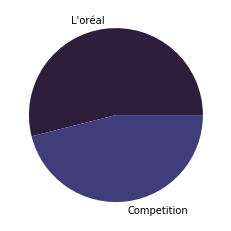

In [4]:
print("The total number of review in this dataset is : "+str(df.shape[0]))
label = ["L'oréal", "Competition"]
quantity = [df[df[comp] == 0].shape[0], df[df[comp] == 1].shape[0]]
plt.pie(quantity, labels = label)

# 1. Retailer Deep Dive

There is a total of 14 retailers in the dataset, let's see how they compare

## <font color='green'>How many retailers are treated by this provider? Who are they?</font>
###### <font color='green'>Insert Answer Here </font>

## <font color='green'>Do customer prefer some retailers to some others?</font>
###### <font color='green'>Insert Answer Here </font>

retailers présent en ligne avec ce que vous avez en tête? en terme de parts de marché?

In [58]:
df[retailer].value_counts()

AMAZON                     1256425
TARGET                      513796
ULTA                        472406
WALGREENS                   451811
WALMART                     393420
CVS                         282768
MACYS                       243862
JET                         204034
SEPHORA                     149468
NORDSTROM                    37854
BLOOMINGDALES                13770
AMAZONPRIMEPANTRY             6548
DERMSTORE                     3079
AMAZONPRIMEPANTRY_45202         10
Name: online_store, dtype: int64

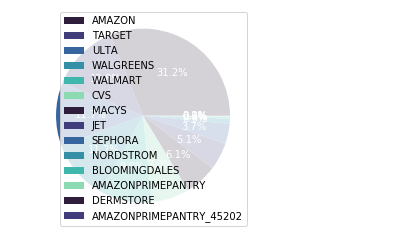

In [60]:
plt.pie(df[retailer].value_counts().values, labels = df[retailer].value_counts().index, autopct='%1.1f%%', textprops=dict(color="w"))
plt.legend(df[retailer].value_counts().index)

Text(0, 0.5, 'Number of ratings')

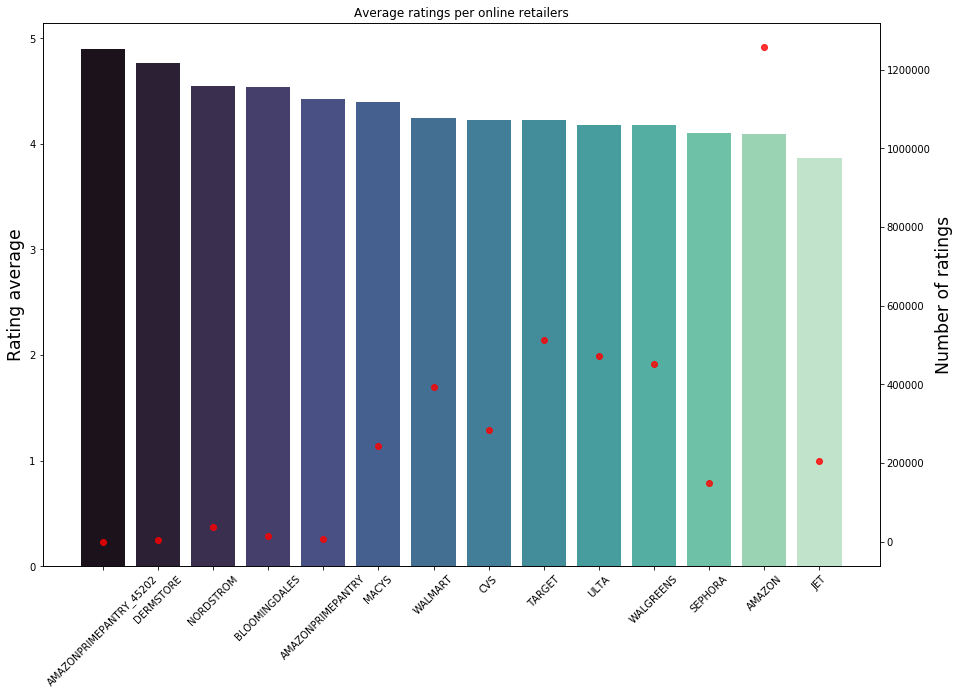

In [5]:
ind = df[[retailer, ratings]].groupby(retailer).mean().sort_values(by = ratings, ascending = False)
val = ind.values.reshape(ind.shape[0])
ind = list(ind.index)

qu = df[[retailer, 'count']].groupby(retailer).sum().to_dict()['count']
quantity = [qu[i] for i in ind]


plt.figure(figsize = (15, 10))
ax = sns.barplot(x = ind, y = val, palette = palette(ind))
plt.xticks(rotation=45)
plt.ylabel('Rating average', fontsize = 'xx-large')
ax2 = ax.twinx()
sns.regplot(x=np.arange(0,val.shape[0]), y=quantity, ax=ax2, color = 'red', fit_reg = False)
plt.title('Average ratings per online retailers')
plt.xlabel('Retailer', fontsize = 'xx-large')
plt.ylabel('Number of ratings', fontsize = 'xx-large')

- Trier par volume
- Scatter plot sur la même graphe avec la volumétrie
- REgarder si on peut mettre le volume en taille de barre horizontale

Text(0, 0.5, 'Rating')

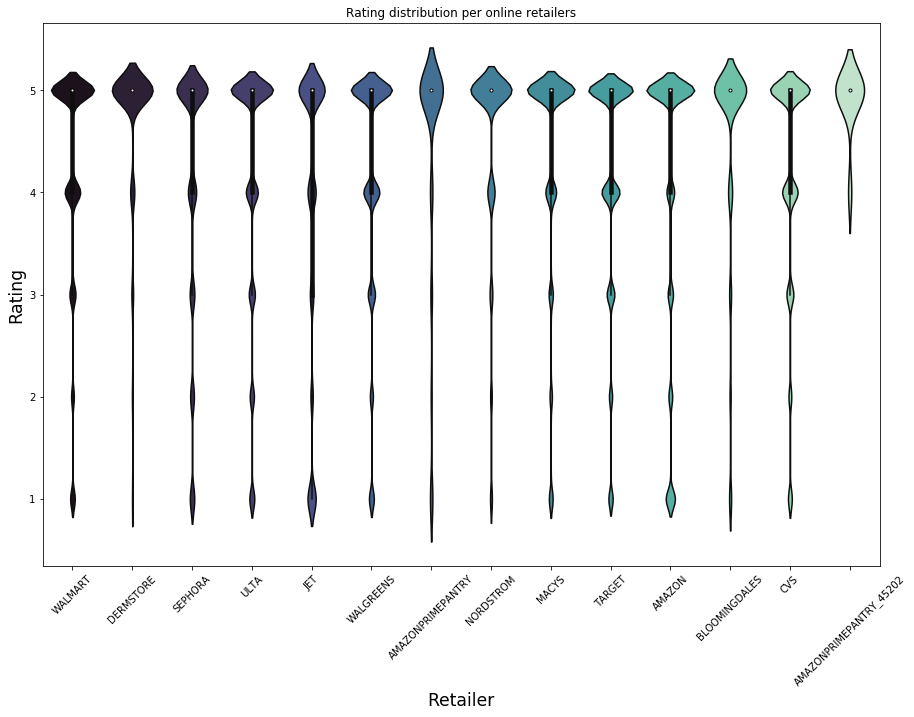

In [6]:
plt.figure(figsize = (15, 10))
sns.violinplot(x=retailer, y=ratings, data=df, palette = palette(df[retailer].unique()))
plt.title('Rating distribution per online retailers')
plt.xticks(rotation=45)
plt.xlabel('Retailer', fontsize = 'xx-large')
plt.ylabel('Rating', fontsize = 'xx-large')

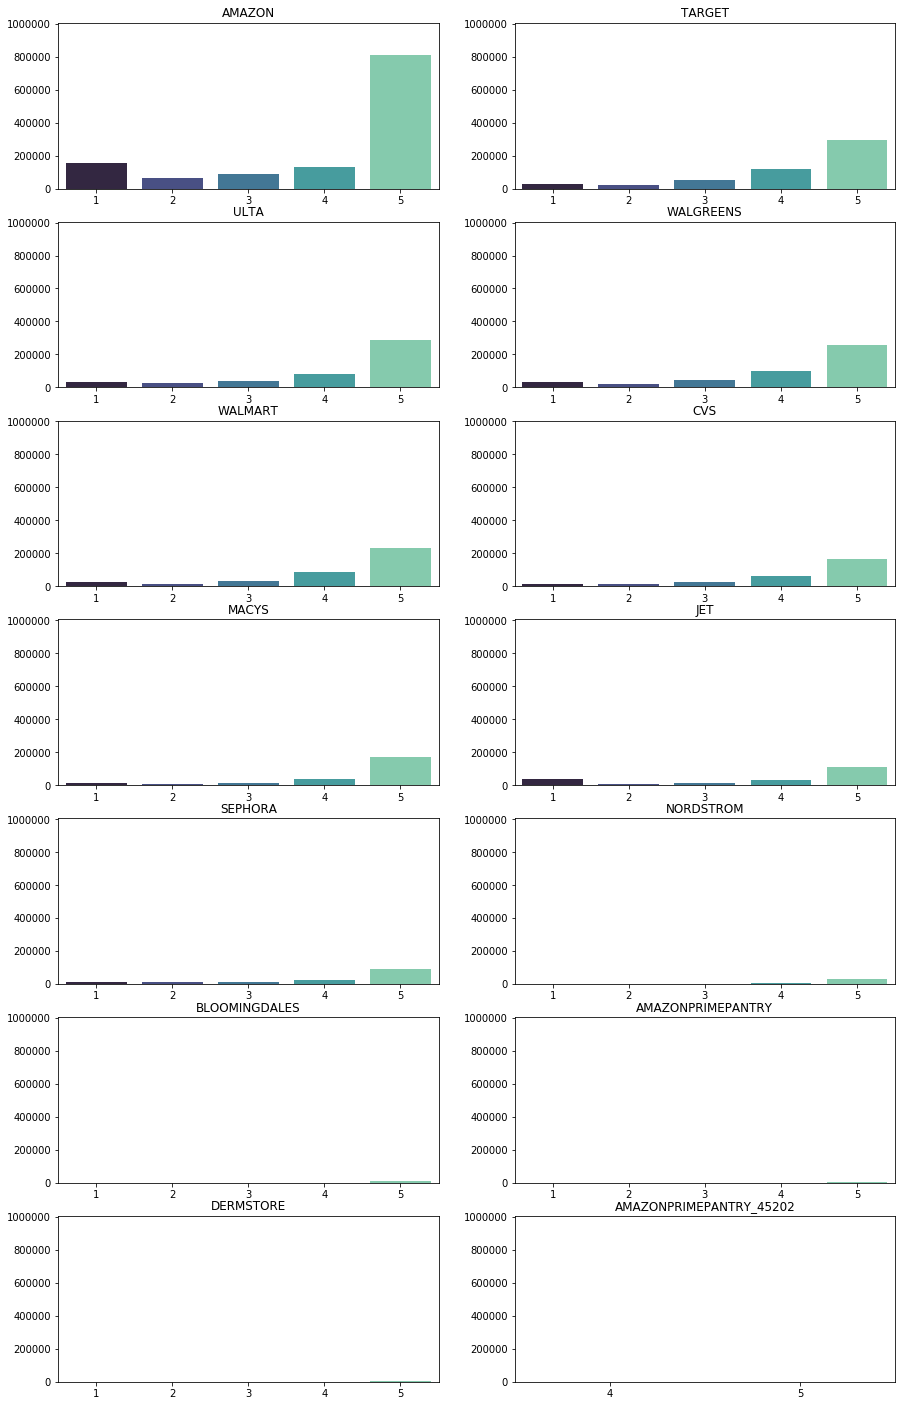

In [63]:
def barplot(ret, ax, i, j):
    d = df[df[retailer] == ret]
    x = d[ratings].value_counts().index
    y = d[ratings].value_counts().values
    return sns.barplot(x = x , y = y, palette = palette(x), ax  =ax[i,j])

f, ax = plt.subplots(7, 2)
f.set_figheight(25)
f.set_figwidth(15)

y_lim = df[retailer].value_counts().values.max()*0.8

for i, elt in enumerate(tqdm(df[retailer].value_counts().index)):
    barplot(elt, ax, i//2, i%2)
    ax[i//2, i%2].set_title(elt)
    ax[i//2, i%2].set_ylim([0,y_lim])

- Mettre sur la même echelle

###### Volume per store and per month

## <font color='green'>Is there a noticeable seasonality for some retailers?</font>
###### <font color='green'>Insert Answer Here </font>

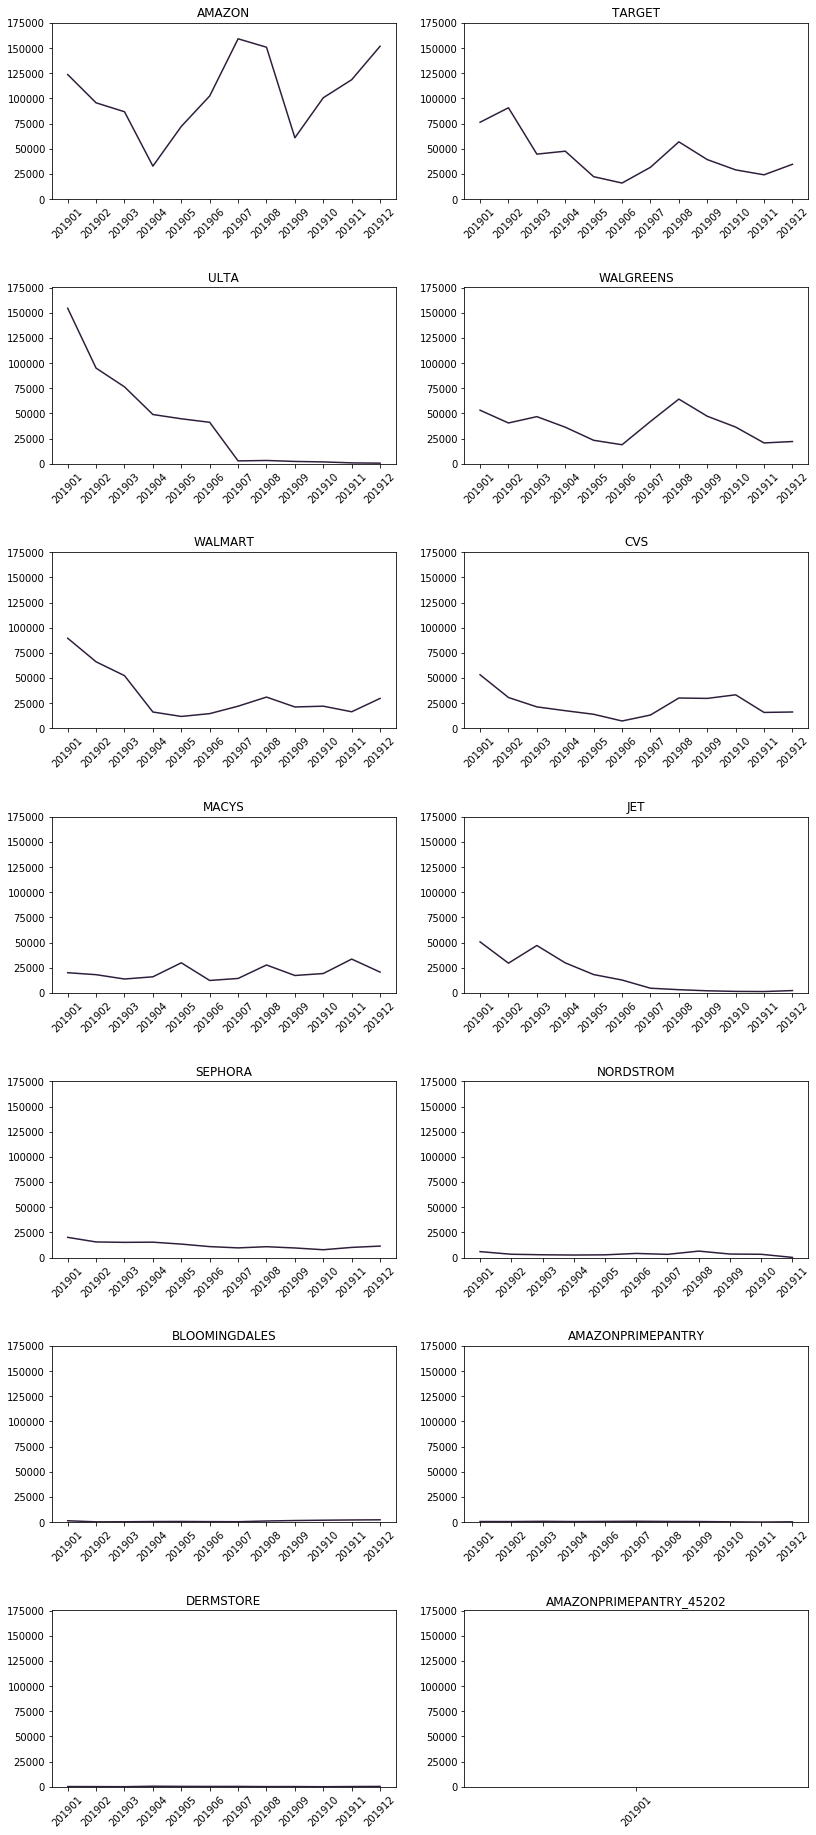

In [8]:
def time_evol(ret, ax, i, j):
    d = df[df[retailer] == ret]
    x = d['annmonth'].value_counts().sort_index()
    y = x.values
    x = np.array(x.index).astype(str)
    return sns.lineplot(x = x , y = y, palette = palette(x), ax  =ax[i,j]), x

f, ax = plt.subplots(7, 2)
f.set_figheight(35)
f.set_figwidth(15)
plt.gcf().subplots_adjust(left = 0.2, bottom = 0.2, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5)

y_lim = df[df[retailer] == df[retailer].value_counts().index[0]]['annmonth'].value_counts().values.max()*1.1


for i, elt in enumerate(tqdm(df[retailer].value_counts().index)):
    plot, x = time_evol(elt, ax, i//2, i%2)
    ax[i//2, i%2].set_title(elt)
    ax[i//2, i%2].set_xticklabels(labels = x, rotation=45)
    ax[i//2, i%2].set_ylim([0,y_lim])


- Mettre à la même echelle sur un même graphe même si certains ecrasent d'autres

###### Vocabulary per brand

In [9]:
def clean(text):
    text1 = text.lower()
    for elt in ",.;?!§/%'&²*µ$£^¨=+_-()#[]":
        text1 = text1.replace(elt,' ')
    return text1

def build_vocab(ret):
    d = df[df[retailer] == ret]
    
    t = clean(" ".join(list(d[text].dropna().values))).split(" ")
    
    dico = {}
    vocab = pd.DataFrame({'word' : t})
    #vocab = pd.DataFrame({'word' : dico.keys(), 'frequency' : dico.values()})
    #vocab = vocab.sort_values(by = 'frequency', ascending = False)
    vocab = vocab['word'].value_counts()
    vocab = pd.DataFrame({'word' : vocab.index, 'frequency' : vocab.values})
    vocab['is_stop'] = vocab['word'].apply(is_stop)
    return vocab
    
    

def build_wordcloud(vocab):
    dico_freq = {}
    for i, elt in enumerate(vocab['word'].values):
        if is_stop(elt) == 0:
            dico_freq[elt] = vocab['frequency'].values[i]
            
    wordcloud = WordCloud(background_color='white', width=600, height=300,
                        max_font_size=100, max_words=30)
    
    wordcloud.generate_from_frequencies(frequencies=dico_freq)
    return wordcloud


stopword = pd.read_csv('stopword.csv', sep = ';')['StopWords'].values
def is_stop(word):
    if word.lower() in stopword:
        return 1
    else:
        return 0

###### 20 Most frequent vocabulary words per retailer (sorted by alphabetic order)

## <font color='green'>Are there any difference in term of vocabulary used by customers for each different retailers?</font>
###### <font color='green'>Insert Answer Here </font>

In [10]:
dico_vocab_retailer = {}
for i, elt in enumerate(tqdm(df[retailer].value_counts().index)):
    dico_vocab_retailer[elt] = build_vocab(elt)
    
dic1 = {}
for elt in dico_vocab_retailer:
    w = dico_vocab_retailer[elt][dico_vocab_retailer[elt]['is_stop']==0]['word'][:21].values
    w.sort()
    dic1[elt] = w
    
pd.DataFrame(dic1).iloc[1:]

AMAZON      TARGET        ULTA   WALGREENS     WALMART         CVS  \
1          buy   collected       color   collected   collected   collected   
2        color       color   concealer       color       color       color   
3     coverage         day    coverage    coverage      colors         day   
4          day  definitely         day         day         day  definitely   
5          dry         dry       doesn         dry  definitely         dry   
6         easy        easy         don        easy         dry        easy   
7   foundation        feel         dry  foundation        easy  foundation   
8         hair  foundation  foundation        hair        feel        hair   
9         its        hair        lips        look  foundation        lips   
10       light        look        look        love        hair        look   
11    lipstick        love       looks        nail        lips        love   
12        look      makeup        love        nice        look      makeup   
13        love        nice       matte      polish        love        nice   
14        nice     product     product     product     product     product   
15     perfect   promotion       shade   promotion   promotion   promotion   
16       price   recommend        skin   recommend   recommend   recommend   
17     product      review        time      review      review      review   
18        skin        skin       tried        skin        skin        skin   
19        time        time          ve        time        time        time   
20       using       using        wear       using       using       using   

         MACYS      JET     SEPHORA   NORDSTROM BLOOMINGDALES  \
1           am       am     amazing          am            am   
2    collected   bought       color   collected        bought   
3        color    brown    coverage       color     collected   
4     coverage    color         day         day         color   
5          day   colour  definitely         dry           day   
6          dry     dark         dry        feel           dry   
7   foundation      dry        feel  foundation          feel   
8        light      dye  foundation        look    foundation   
9     lipstick     easy        its        love          hair   
10        look  formula      little      makeup          its   
11        love     hair        look     perfect          look   
12     perfect     love        love      powder          love   
13     product  natural      makeup     product       product   
14   promotion     nice        oily   promotion     promotion   
15   recommend  product     perfect   recommend        review   
16      review     skin     product      review         scent   
17       shade    smell        skin     setting          skin   
18        skin     time        time        skin         smell   
19        time    using       tried        time          time   
20       using       ve       using       using         using   

   AMAZONPRIMEPANTRY      DERMSTORE AMAZONPRIMEPANTRY_45202  
1        conditioner           acne                   aware  
2                dry             am                     bad  
3               hair          cream                  bottle  
4               its            day                     buy  
5             lotion     difference                cetaphil  
6               love            dry                 closest  
7              makes           feel             consistency  
8               nice          feels              definitely  
9              price           its                  hassle  
10           product         little                    hour  
11          products           love                 lasting  
12             scent    moisturizer                    love  
13         sensitive        product                   price  
14           shampoo       products                 product  
15              skin      sensitive               recommend  
16         

- Faire une liste des mots en commun par marque

In [11]:
dico_unique = {}

for elt in dic1:
    for word in dic1[elt]:
        if word in dico_unique:
            dico_unique[word] += 1
        else:
            dico_unique[word] = 1

dataframe = pd.DataFrame({'word' : list(dico_unique.keys()) , 'nb_retailers' : list(dico_unique.values())})
dataframe = dataframe.sort_values(by = 'nb_retailers', ascending = False)
dataframe.iloc[1:].head(10)

word  nb_retailers
13        love            14
18        skin            14
17     product            14
5          dry            13
19        time            12
20       using            12
2        color            11
4          day            11
12        look            10
7   foundation            10

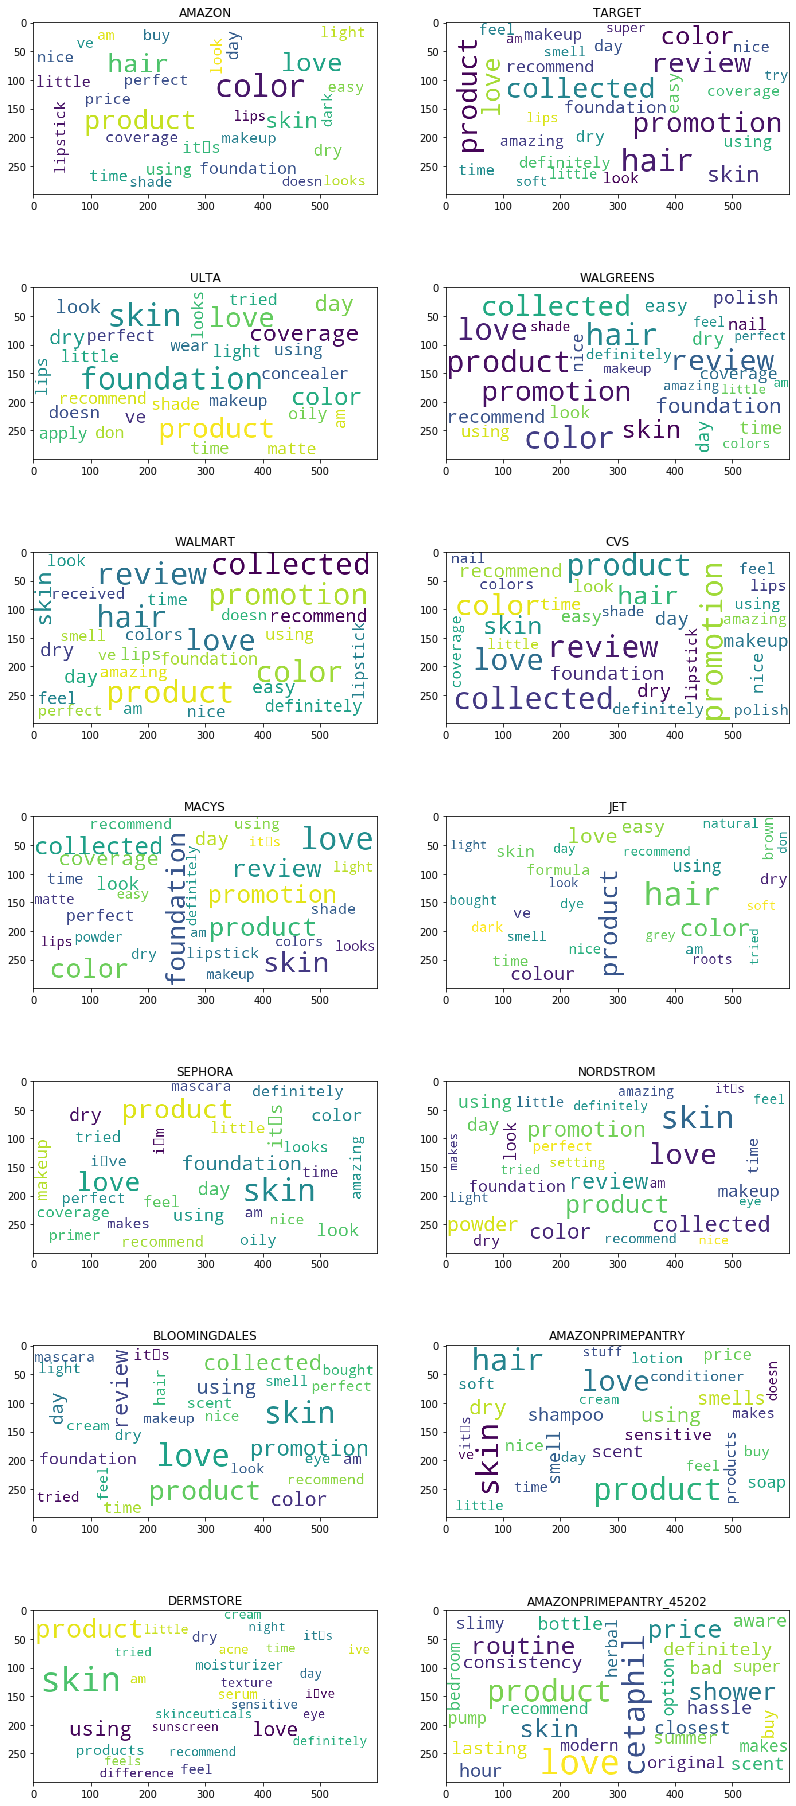

In [12]:
f, ax = plt.subplots(7, 2)
f.set_figheight(35)
f.set_figwidth(15)
plt.gcf().subplots_adjust(left = 0.2, bottom = 0.2, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5)

for i, elt in enumerate(tqdm(df[retailer].value_counts().index)):
    ax[i//2, i%2].imshow(build_wordcloud(dico_vocab_retailer[elt]))
    ax[i//2, i%2].title.set_text(elt)

###### Category per retailer

## <font color='green'>What category of product are sold by each retailers?</font>
###### <font color='green'>Insert Answer Here </font>

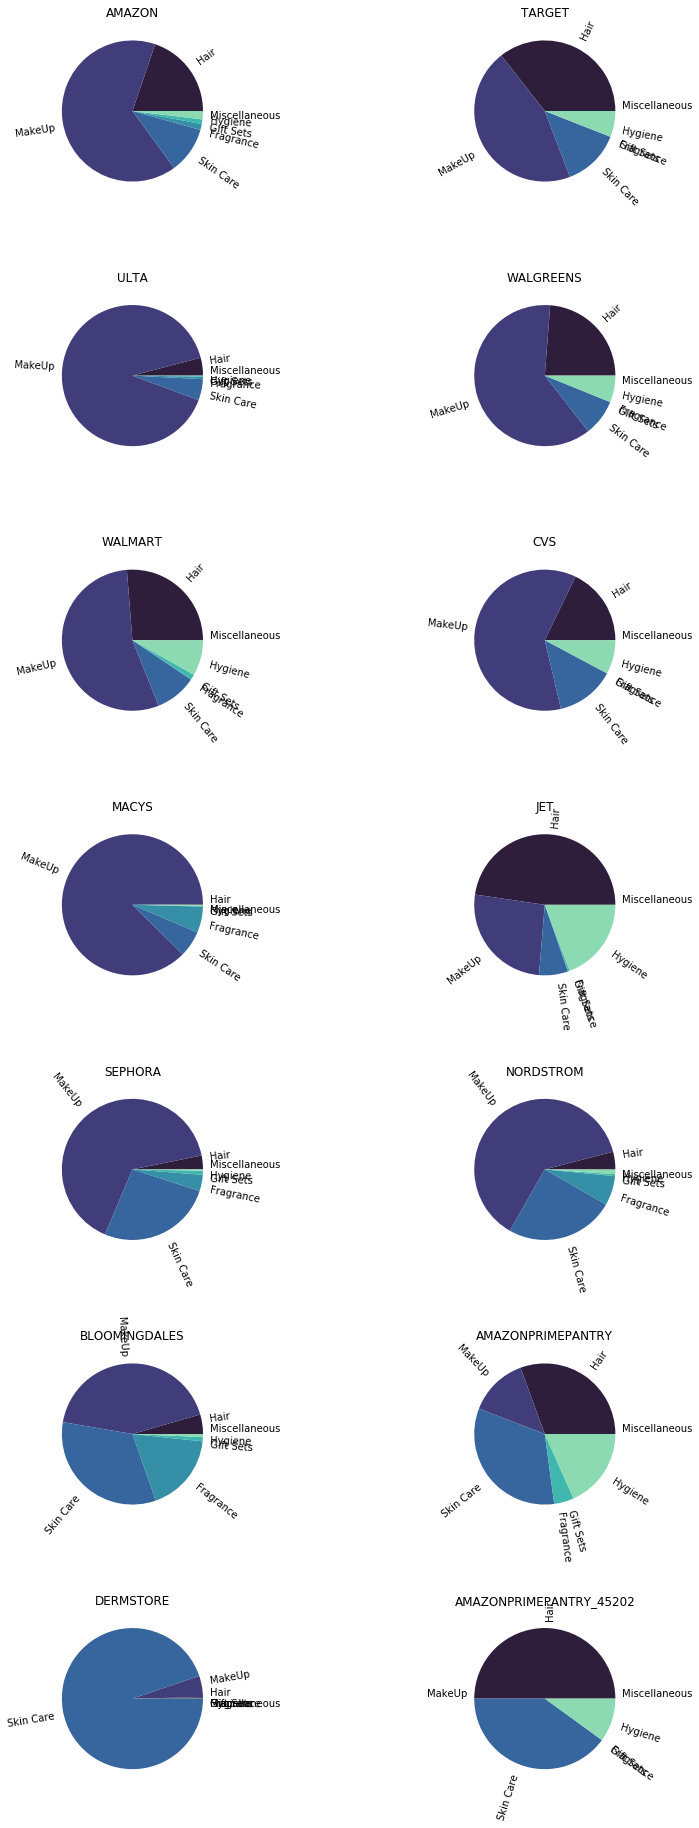

In [13]:
cats = ['Hair', 'MakeUp', 'Skin Care', 'Fragrance', 'Gift Sets', 'Hygiene', 'Miscellaneous']




def cat_pie(ret):
    d = df[df[retailer] == ret]
    vc = d[category].value_counts()
    for elt in cats:
        if not(elt in vc.index):
            vc.loc[elt] = 0
    vc = vc.loc[cats]
    return vc

f, ax = plt.subplots(7, 2)
f.set_figheight(35)
f.set_figwidth(15)
plt.gcf().subplots_adjust(left = 0.2, bottom = 0.2, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5)

for i, elt in enumerate(tqdm(df[retailer].value_counts().index)):
    vc = cat_pie(elt)
    ax[i//2, i%2].pie(vc.values, labels = vc.index, rotatelabels = 45)
    ax[i//2, i%2].title.set_text(elt)

- Mettre les mêmes couleurs

###### Brands per retailer

## <font color='green'>What brands are sold by each retailers?</font>
###### <font color='green'>Insert Answer Here </font>

Top 10 brands per number of reviews for each retailers

Only l'oréal brands 

In [14]:
top_n = 10

def get_top_brands(ret):
    d = df[(df[retailer] == ret)&(df[comp] == 0)]
    br = d[brands].value_counts().iloc[:10].index
    if len(br)<10:
        br = np.concatenate([br, np.array(["" for elt in range(10-len(br))])])
    return br

dico_brands = {}
for i, elt in enumerate(tqdm(df[retailer].value_counts().index)):
    dico_brands[elt] = get_top_brands(elt)

top_brands = list(df[df[comp] == 0][brands].value_counts().index[:top_n])
p = sns.color_palette("pastel", n_colors = top_n)

def rgb_to_hex(tuple):
    return '#%02x%02x%02x' % (int(tuple[0]*255), int(tuple[1]*255), int(tuple[2]*255))

dicolor = {}
for i, elt in enumerate(top_brands):
    dicolor[elt] = rgb_to_hex(p[i])
    

    
def color_negative_red(val):
    try:
        color = dicolor[val]
    except:
        color = 'white'
    return 'background-color: %s' % color

pd.DataFrame(dico_brands).style.applymap(color_negative_red)

Only competition brands

In [15]:
def get_top_brands(ret):
    d = df[(df[retailer] == ret)&(df[comp] == 1)]
    br = d[brands].value_counts().iloc[:10].index
    if len(br)<10:
        br = np.concatenate([br, np.array(["" for elt in range(10-len(br))])])
    return br

top_brands = list(df[df[comp] == 1][brands].value_counts().index[:top_n])
p = sns.color_palette("pastel", n_colors = top_n)
dicolor = {}
for i, elt in enumerate(top_brands):
    dicolor[elt] = rgb_to_hex(p[i])


dico_brands = {}
for i, elt in enumerate(tqdm(df[retailer].value_counts().index)):
    dico_brands[elt] = get_top_brands(elt)
    
pd.DataFrame(dico_brands).style.applymap(color_negative_red)

# 2. Brand deep dive

## <font color='green'>What are the main brands taken into account by the provider?</font>
###### <font color='green'>Insert Answer Here </font>

## <font color='green'>Are there any important brands missing?</font>
###### <font color='green'>Insert Answer Here </font>

Here we will focus on the brands that are the most represented inside the dataset, both for l'oréal and for it's competitors

L'oréal brands sorted per volume

In [16]:
top_10_l = df[df[comp] == 0 ][brands].value_counts().index[:10]
df[df[comp] == 0][brands].value_counts()

L'Oréal Paris                   666344
Maybelline New York             473256
Garnier                         420527
NYX                             291965
essie                            85039
IT Cosmetics                     53260
Lancôme                          38473
Urban Decay                      24254
CeraVe                           18482
Dermablend                       15874
Giorgio Armani Fragrance          9656
Carol's Daughter                  8513
Biolage                           7113
La Roche-Posay                    6886
Kiehl's Since 1851                6264
Softsheen Carson                  4652
Vichy                             4077
Pureology                         3758
Yves Saint Laurent Beauty         3633
Redken                            3601
Clarisonic                        3252
Giorgio Armani Beauty             3191
Yves Saint Laurent Fragrance      2982
Matrix                            2982
Skinceuticals                     2441
Guy Laroche              

Top 30 Competitor brands per volume : 

In [17]:
top_10_c = df[df[comp] == 1][brands].value_counts().index[:10]
df[df[comp] == 1][brands].value_counts().head(30)

Revlon                      274071
Cover Girl                  215508
Dove                        203156
Clairol                     130607
Sally Hansen                114895
Neutrogena                   70651
Burt's Bees                  64272
Bareminerals                 47040
Nars Cosmetics               44909
Pantene                      42157
Tarte                        41381
Mac Cosmetics                41190
Olay                         40117
Anastassia Beverly Hills     39494
Clinique                     29476
Elf cosmetics                28578
Too Faced                    26873
John Frieda                  22642
Laura Mercier                20591
Milani                       19236
Benefit                      17919
Aveeno                       17565
Physicians Formula           17071
Aussie                       16047
Estée Lauder                 15703
Philosophy                   13835
Tresemme                     13322
Smashbox                     12878
Stila               

Average rating per brand on top 10 l'oréal

## <font color='green'>What brands are considered as premium in term of reviews?</font>
###### <font color='green'>Insert Answer Here </font>

Text(0, 0.5, 'Number of ratings')

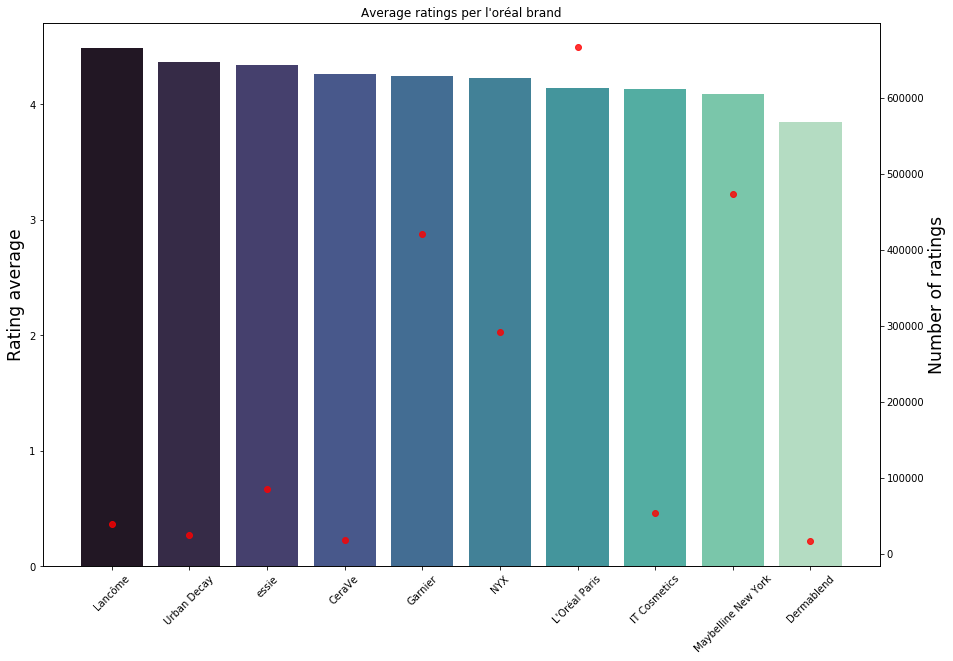

In [18]:
ind = df[[brands, ratings]].groupby(brands).mean().loc[top_10_l].sort_values(by = ratings, ascending = False)
val = ind.values.reshape(ind.shape[0])
ind = list(ind.index)

qu = df[[brands, 'count']].groupby(brands).sum().to_dict()['count']
quantity = [qu[i] for i in ind]


plt.figure(figsize = (15, 10))
ax = sns.barplot(x = ind, y = val, palette = palette(ind))
plt.xticks(rotation=45)
plt.ylabel('Rating average', fontsize = 'xx-large')
ax2 = ax.twinx()
sns.regplot(x=np.arange(0,val.shape[0]), y=quantity, ax=ax2, color = 'red', fit_reg = False)
plt.title("Average ratings per l'oréal brand")
plt.xlabel('Brand', fontsize = 'xx-large')
plt.ylabel('Number of ratings', fontsize = 'xx-large')

Text(0, 0.5, 'Rating')

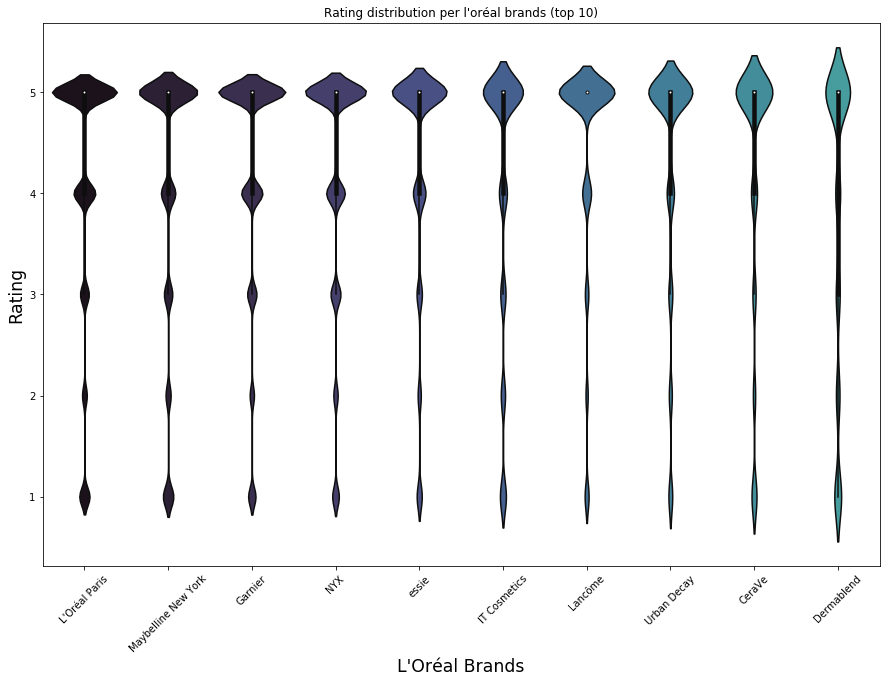

In [65]:
plt.figure(figsize = (15, 10))
sns.violinplot(x=brands, y=ratings, data=df.loc[top_10_l], palette = palette(df[retailer].unique()))
plt.title("Rating distribution per l'oréal brands (top 10)")
plt.xticks(rotation=45)
plt.xlabel("L'Oréal Brands", fontsize = 'xx-large')
plt.ylabel('Rating', fontsize = 'xx-large')

Text(0, 0.5, 'Number of ratings')

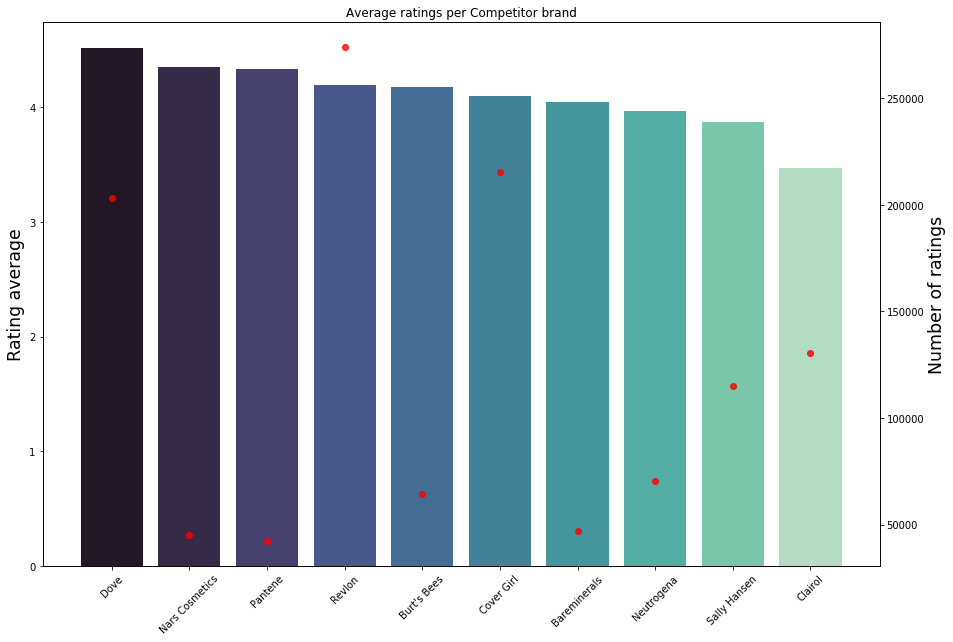

In [20]:
ind = df[[brands, ratings]].groupby(brands).mean().loc[top_10_c].sort_values(by = ratings, ascending = False)
val = ind.values.reshape(ind.shape[0])
ind = list(ind.index)

qu = df[[brands, 'count']].groupby(brands).sum().to_dict()['count']
quantity = [qu[i] for i in ind]


plt.figure(figsize = (15, 10))
ax = sns.barplot(x = ind, y = val, palette = palette(ind))
plt.xticks(rotation=45)
plt.ylabel('Rating average', fontsize = 'xx-large')
ax2 = ax.twinx()
sns.regplot(x=np.arange(0,val.shape[0]), y=quantity, ax=ax2, color = 'red', fit_reg = False)
plt.title("Average ratings per Competitor brand")
plt.xlabel('Brand', fontsize = 'xx-large')
plt.ylabel('Number of ratings', fontsize = 'xx-large')

Text(0, 0.5, 'Rating')

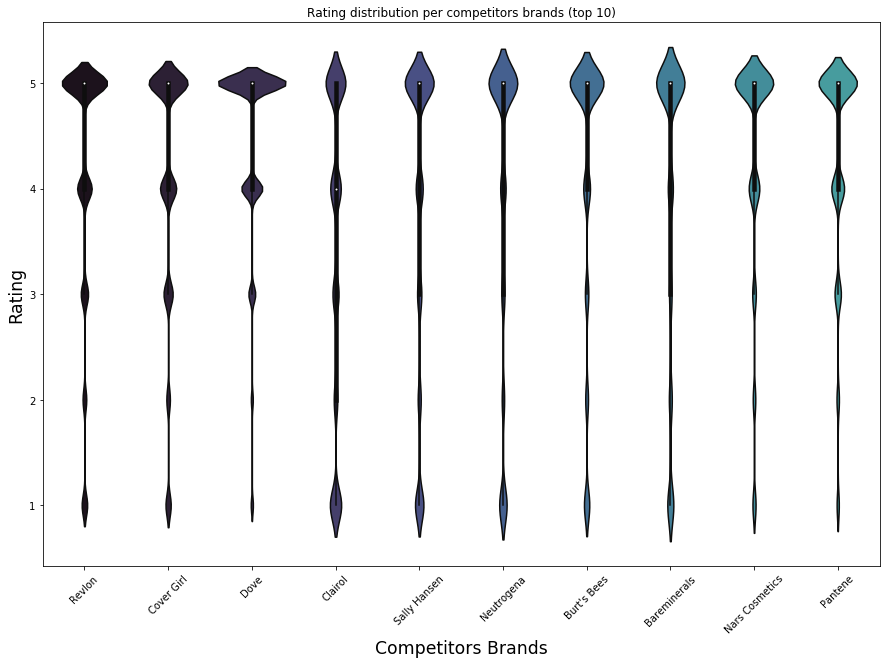

In [54]:
plt.figure(figsize = (15, 10))
df.index = df[brands]
sns.violinplot(x=brands, y=ratings, data=df.loc[top_10_c], palette = palette(df[retailer].unique()))
plt.title("Rating distribution per competitors brands (top 10)")
plt.xticks(rotation=45)
plt.xlabel('Competitors Brands', fontsize = 'xx-large')
plt.ylabel('Rating', fontsize = 'xx-large')

In [22]:
def build_vocab(bra):
    d = df[df[brands] == bra]
    
    t = clean(" ".join(list(d[text].dropna().values))).split(" ")
    
    dico = {}
    vocab = pd.DataFrame({'word' : t})
    #vocab = pd.DataFrame({'word' : dico.keys(), 'frequency' : dico.values()})
    #vocab = vocab.sort_values(by = 'frequency', ascending = False)
    vocab = vocab['word'].value_counts()
    vocab = pd.DataFrame({'word' : vocab.index, 'frequency' : vocab.values})
    vocab['is_stop'] = vocab['word'].apply(is_stop)
    return vocab

## <font color='green'>Are there any differences in term of vocabulary between brands?</font>
###### <font color='green'>Insert Answer Here </font>

###### Common vocabulary of top 10 l'oréal brands

In [23]:
dico_vocab_brands_l = {}
for i, elt in enumerate(tqdm(top_10_l)):
    dico_vocab_brands_l[elt] = build_vocab(elt)
    
dic1 = {}
for elt in dico_vocab_brands_l:
    w = dico_vocab_brands_l[elt][dico_vocab_brands_l[elt]['is_stop']==0]['word'][:21].values
    w.sort()
    dic1[elt] = w
    
pd.DataFrame(dic1).iloc[1:]

L'Oréal Paris Maybelline New York    Garnier         NYX      essie  \
1             am               color    amazing       color  beautiful   
2      collected           concealer  collected    coverage      brand   
3          color            coverage      color         day       coat   
4         colors                 day        dye  definitely      coats   
5       coverage                 dry       easy         dry      color   
6            day                easy       feel  foundation     colors   
7            dry          foundation    garnier         lip       easy   
8           easy                lips       hair        lips      essie   
9     foundation            lipstick       love        look       love   
10          hair              little     makeup        love       nail   
11          lips                look    product       matte      nails   
12      lipstick                love  promotion        nice       nice   
13          look              makeup  recommend         nyx    perfect   
14          love               matte     review        oily       pink   
15         matte          maybelline       skin     perfect     polish   
16       product             perfect      smell       price     pretty   
17     promotion             product       soft     product    product   
18      received               shade       time   recommend  recommend   
19        review                skin      using       shade       time   
20          skin                time      water        skin        top   

   IT Cosmetics     Lancôme Urban Decay        CeraVe  Dermablend  
1            cc          am       color        cerave          am  
2         color   collected      colors      cleanser       color  
3     concealer       color    coverage     collected       cover  
4      coverage    coverage         day         cream    coverage  
5         cream         day         eye           dry      covers  
6           day         eye        eyes          feel         day  
7           dry  foundation  foundation        greasy  dermablend  
8           eye     lancome        lips        lotion  foundation  
9    foundation      lashes    lipstick          love      little  
10         goes        look        look   moisturizer        look  
11        light        love       looks  moisturizing       looks  
12       little      makeup        love       product        love  
13         look     mascara      makeup      products      makeup  
14         love     product     perfect     promotion      powder  
15       makeup   promotion      primer        review     product  
16      product      review     product     sensitive     setting  
17         skin        skin       shade          skin        skin  
18        tried        time        skin         using       tried  
19        using       tried       stays            ve       using  
20           ve       using        time          wash          ve

In [24]:
dico_unique = {}

for elt in dic1:
    for word in dic1[elt]:
        if word in dico_unique:
            dico_unique[word] += 1
        else:
            dico_unique[word] = 1

dataframe = pd.DataFrame({'word' : list(dico_unique.keys()) , 'nb_brands' : list(dico_unique.values())})
dataframe = dataframe.sort_values(by = 'nb_brands', ascending = False)
dataframe.iloc[1:].head(10)

word  nb_brands
16     product         10
14        love         10
3        color          9
20        skin          9
13        look          7
5     coverage          7
6          day          7
9   foundation          7
23      makeup          6
27        time          5

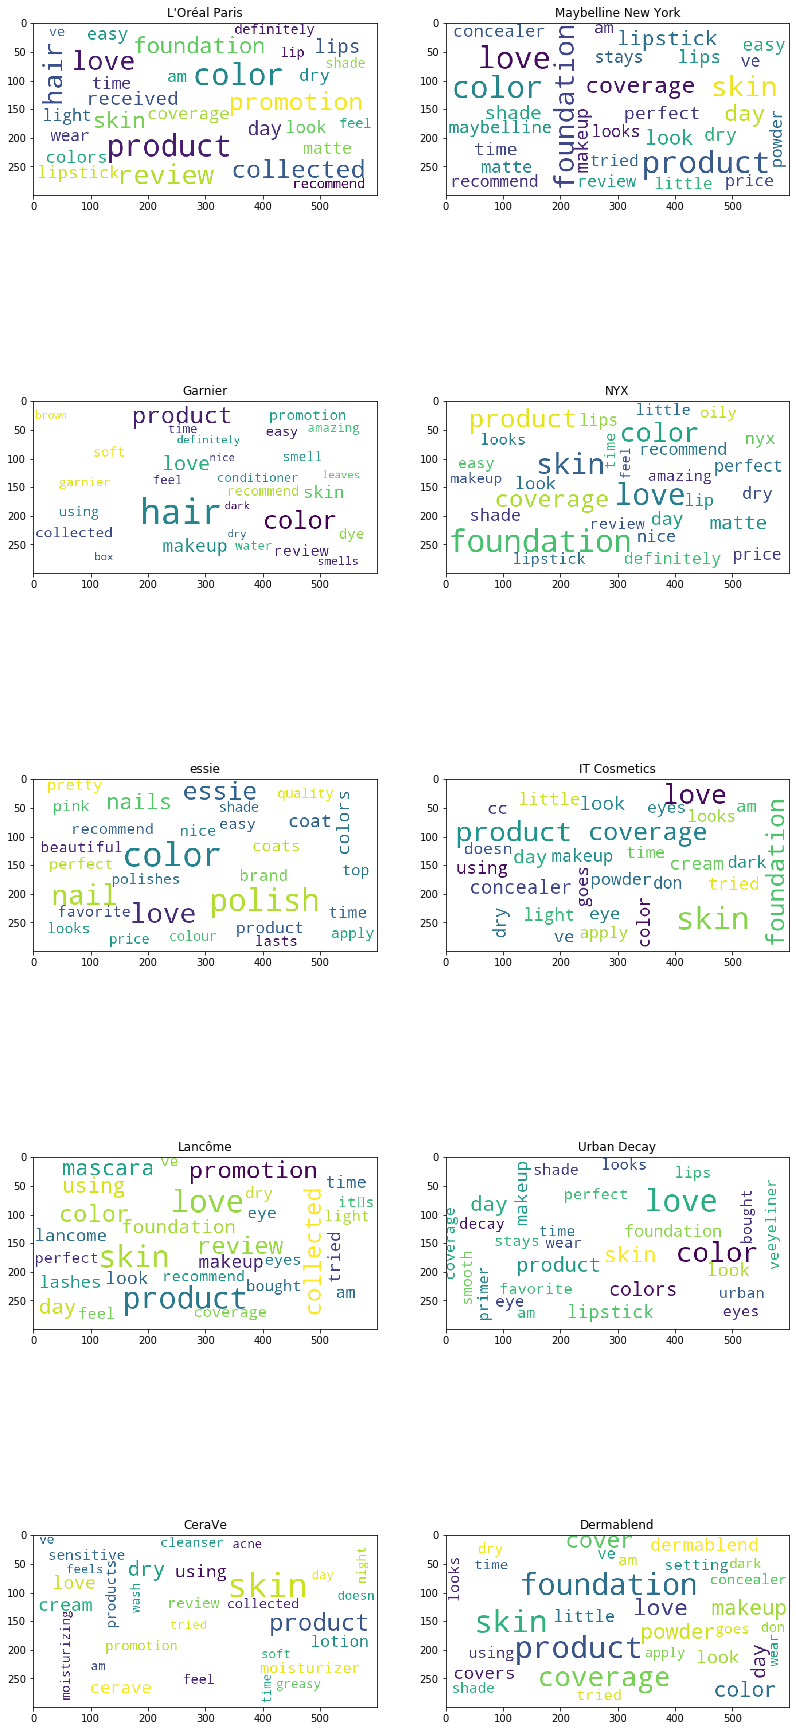

In [25]:
f, ax = plt.subplots(5, 2)
f.set_figheight(35)
f.set_figwidth(15)
plt.gcf().subplots_adjust(left = 0.2, bottom = 0.2, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5)

for i, elt in enumerate(tqdm(top_10_l)):
    ax[i//2, i%2].imshow(build_wordcloud(dico_vocab_brands_l[elt]))
    ax[i//2, i%2].title.set_text(elt)

###### Common vocabulary of top 10 competitors brands

In [26]:
dico_vocab_brands_c = {}
for i, elt in enumerate(tqdm(top_10_c)):
    dico_vocab_brands_c[elt] = build_vocab(elt)
    
dic1 = {}
for elt in dico_vocab_brands_c:
    w = dico_vocab_brands_c[elt][dico_vocab_brands_c[elt]['is_stop']==0]['word'][:21].values
    w.sort()
    dic1[elt] = w
    
pd.DataFrame(dic1).iloc[1:]

Revlon  Cover Girl       Dove    Clairol Sally Hansen  Neutrogena  \
1   collected         buy       body      brown         coat        acne   
2       color       color      clean  collected        coats          am   
3       gloss    coverage  collected      color    collected      bought   
4        hair   covergirl        day     colour        color       color   
5         lip         day  deodorant      cover       colors         day   
6        lips  definitely       dove       dark         days         dry   
7    lipstick        easy        dry        dye          dry        feel   
8        look  foundation      fresh       easy         easy  foundation   
9        love      lashes       love    formula          gel        love   
10       nail    lipstick       nice       grey       hansen      makeup   
11       nice        look    product       hair         love  neutrogena   
12       pink        love  promotion    natural         nail     product   
13     polish      makeup  recommend       nice        nails    products   
14     pretty     mascara     review    product       polish   sensitive   
15    product        nice      scent  promotion      product        skin   
16  promotion       price       skin     review    promotion        time   
17     review     product      smell      roots       review       tried   
18     revlon   recommend     smells       time        sally       using   
19      shade        skin      spray      touch         time          ve   
20       time        time       wash      using          top       wipes   

   Burt's Bees Bareminerals Nars Cosmetics      Pantene  
1         balm           am      collected      amazing  
2         bees         bare          color        clean  
3         burt        color      concealer  conditioner  
4    collected     coverage       coverage          dry  
5        color          day            day         feel  
6          dry   foundation            dry      feeling  
7         feel        light     foundation         hair  
8          lip         look          light       leaves  
9         lips        looks           look         love  
10    lipstick         love          looks        makes  
11        love       makeup           love         nice  
12     natural     minerals           nars      pantene  
13        nice      perfect        natural      product  
14     product       powder        perfect     products  
15    products      product        product    recommend  
16   promotion        shade      promotion      shampoo  
17      review         skin         review        smell  
18       satin        tried          shade       smells  
19        skin        using           skin         soft  
20      smooth           ve          tried        using

In [27]:
dico_unique = {}

for elt in dic1:
    for word in dic1[elt]:
        if word in dico_unique:
            dico_unique[word] += 1
        else:
            dico_unique[word] = 1

dataframe = pd.DataFrame({'word' : list(dico_unique.keys()) , 'nb_brands' : list(dico_unique.values())})
dataframe = dataframe.sort_values(by = 'nb_brands', ascending = False)
dataframe.iloc[1:].head(10)

word  nb_brands
15    product         10
9        love          9
2       color          8
11       nice          6
1   collected          6
38        dry          6
33       skin          6
17     review          6
16  promotion          6
24        day          5

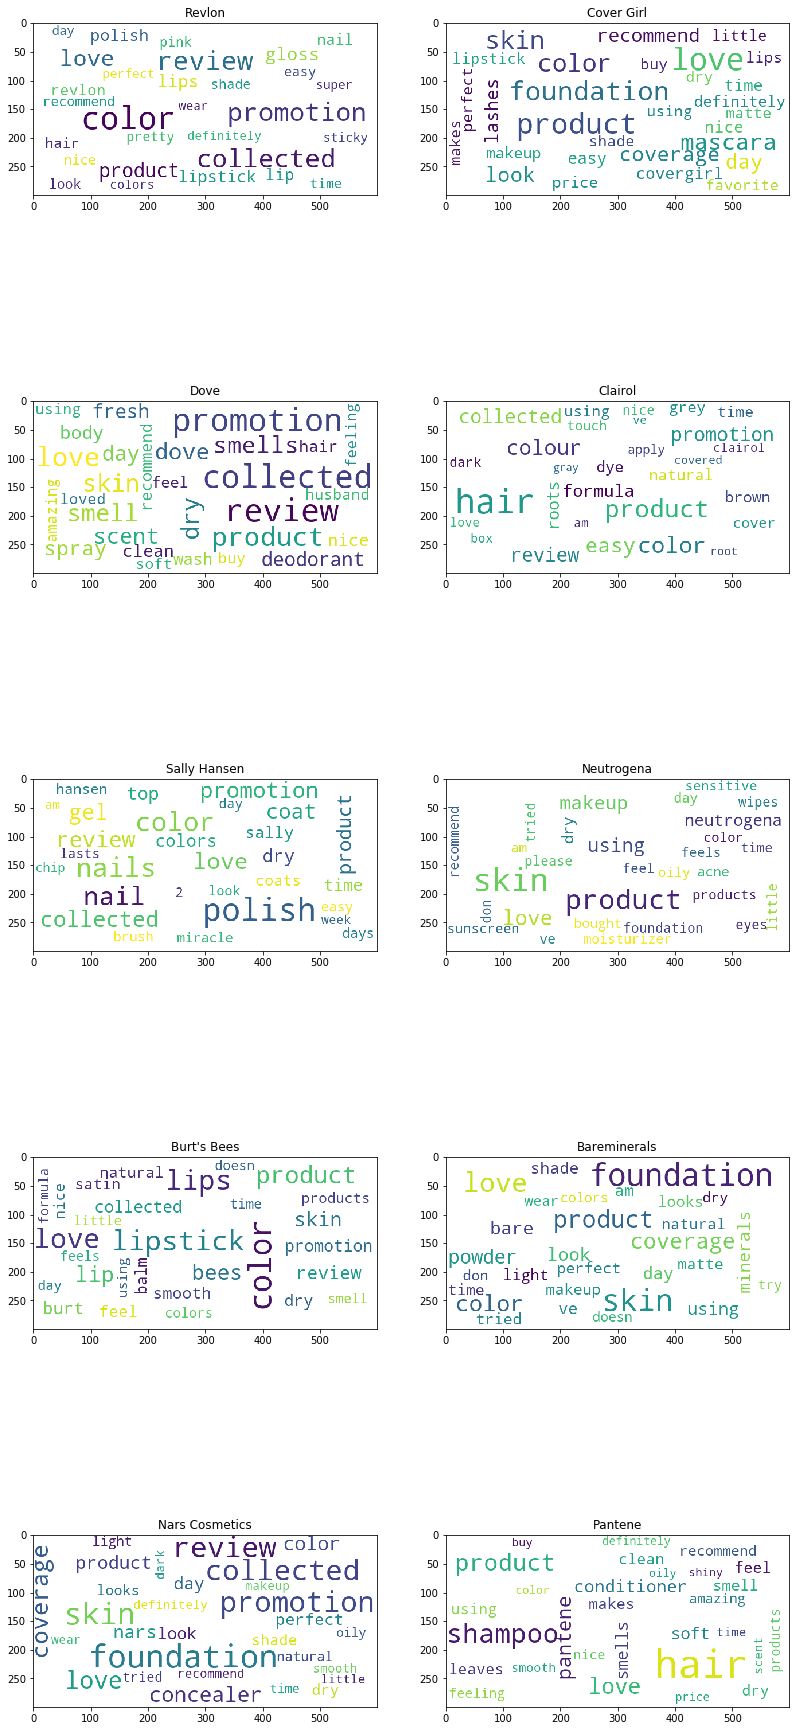

In [28]:
f, ax = plt.subplots(5, 2)
f.set_figheight(35)
f.set_figwidth(15)
plt.gcf().subplots_adjust(left = 0.2, bottom = 0.2, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5)

for i, elt in enumerate(tqdm(top_10_c)):
    ax[i//2, i%2].imshow(build_wordcloud(dico_vocab_brands_c[elt]))
    ax[i//2, i%2].title.set_text(elt)

## <font color='green'>How many product are taken into account for each brands?</font>
###### <font color='green'>Insert Answer Here </font>

###### Number of unique product covered by each brand

In [29]:
product_brands = df[[brands, product_description, comp]].drop_duplicates()

###### L'oréal

In [30]:
product_brands[product_brands[comp] == 0][brands].value_counts()

L'Oréal Paris                   5801
NYX                             4990
Maybelline New York             4192
Garnier                         1605
Lancôme                         1301
essie                            991
Kiehl's Since 1851               611
Urban Decay                      593
IT Cosmetics                     507
Yves Saint Laurent Beauty        341
CeraVe                           335
La Roche-Posay                   325
Dermablend                       306
Softsheen Carson                 269
Carol's Daughter                 262
Biolage                          233
Vichy                            230
Giorgio Armani Beauty            201
Redken                           148
Giorgio Armani Fragrance         137
Pureology                        136
Yves Saint Laurent Fragrance     134
Matrix                           128
Ralph Lauren                     116
Baxter of California             108
Clarisonic                       102
Viktor & Rolf                     79
K

###### Competition

In [31]:
product_brands[product_brands[comp] == 1][brands].value_counts().head(30)

Revlon                      3258
Cover Girl                  2742
Neutrogena                  2387
Clinique                    1617
Elf cosmetics               1503
Dove                        1502
Sally Hansen                1484
Burt's Bees                 1423
Mac Cosmetics               1231
Bareminerals                1143
Nars Cosmetics              1122
Olay                        1032
Dior                        1007
Estée Lauder                 894
Clairol                      868
Anastassia Beverly Hills     828
Pantene                      780
Laura Mercier                655
Physicians Formula           642
Milani                       606
Smashbox                     603
Bobbi Brown Cosmetics        550
Philosophy                   548
The Body Shop                536
Tarte                        536
Aveeno                       471
Benefit                      436
Tresemme                     436
Suave                        429
Stila                        404
Name: bran

# 3. Category Deep Dive

## <font color='green'>What is the proportion of reviews along each category from the provider?</font>
###### <font color='green'>Insert Answer Here </font>

###### Volume per category

MakeUp           2540530
Hair              818252
Skin Care         424263
Hygiene           178134
Fragrance          46097
Gift Sets          21909
Miscellaneous         66
Name: category, dtype: int64

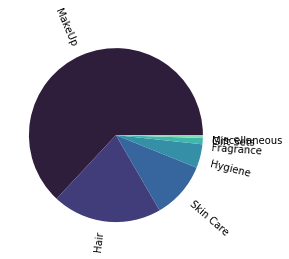

In [32]:
vc = df[category].value_counts()
plt.pie(vc.values, labels = vc.index, rotatelabels = 45)
vc.head(10)

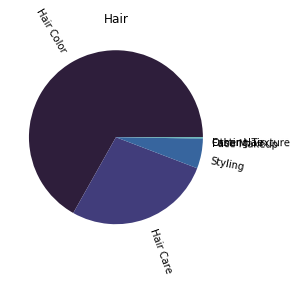

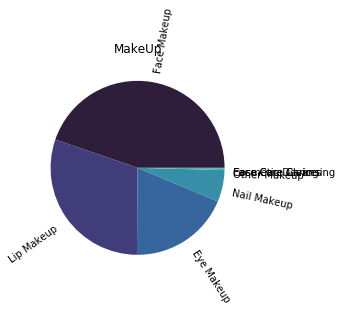

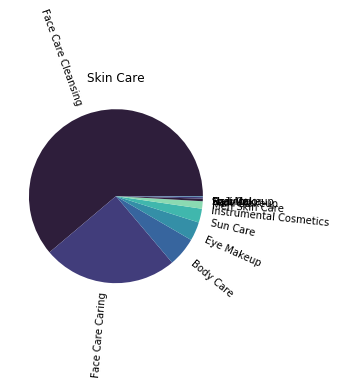

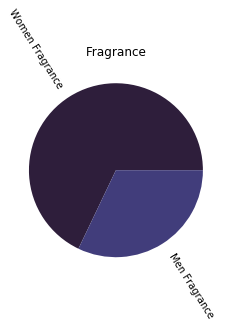

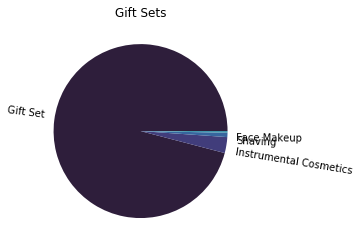

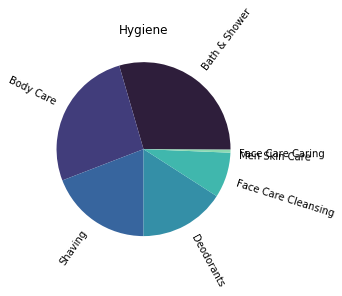

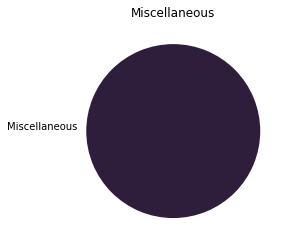

In [69]:
for i, elt in enumerate(df[category].unique()):
    plt.figure(i)

    vc = df[df[category] == elt]['dimension1'].value_counts()
    plt.pie(vc.values, labels = vc.index, rotatelabels = 45)
    plt.title(elt)
    vc.head(10)

###### Category sold by each top 10 l'oréal brands

## <font color='green'>What is the proportion of reviews along each category from the provider for each brand?</font>
###### <font color='green'>Insert Answer Here </font>

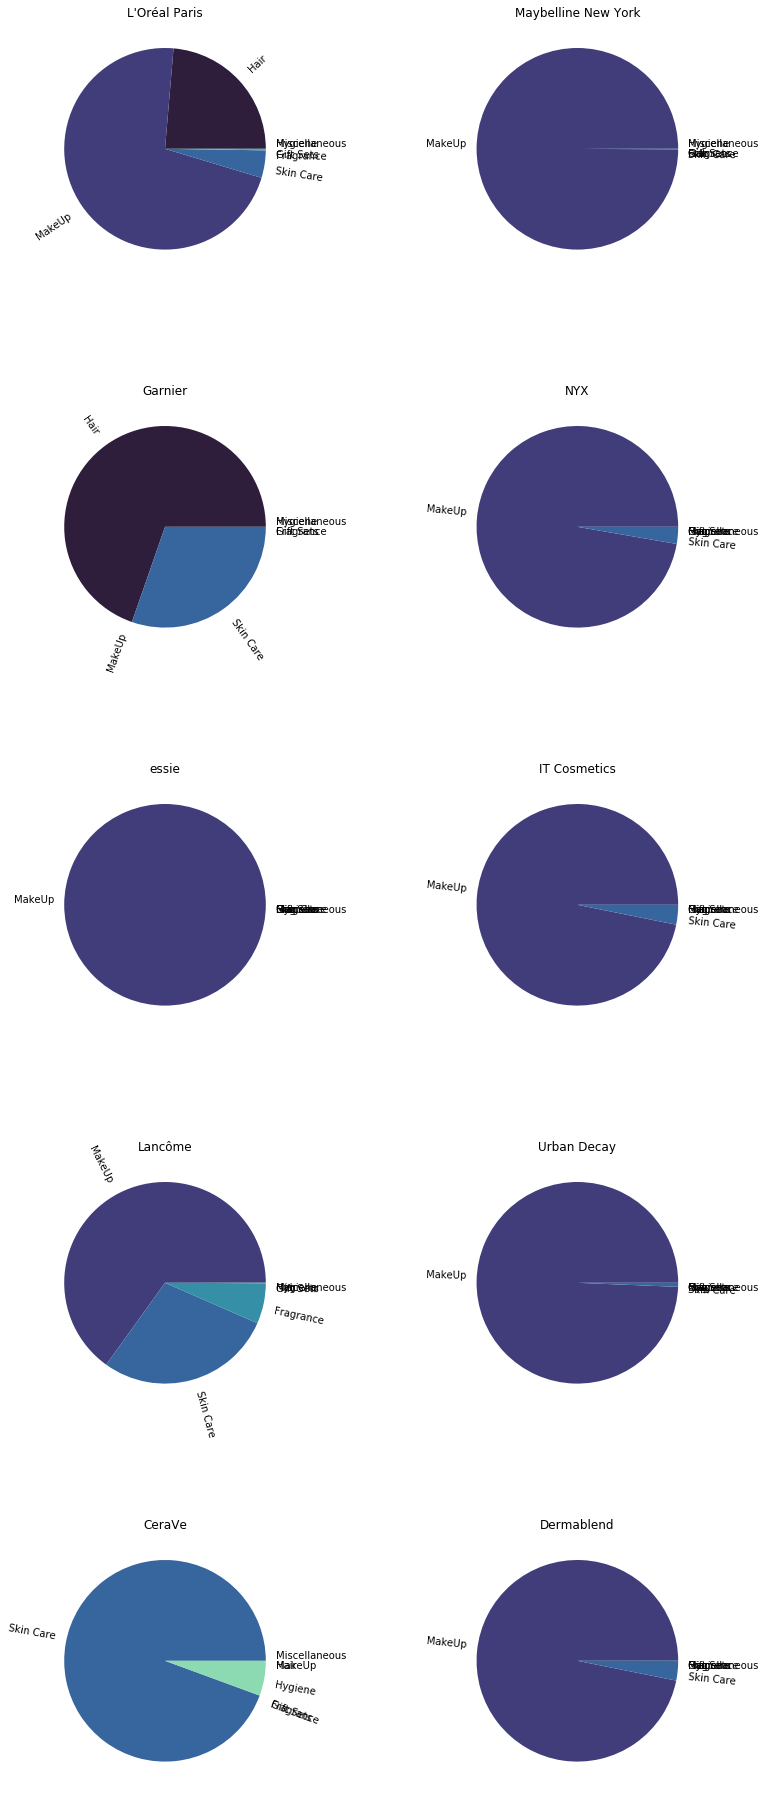

In [33]:

cats = ['Hair', 'MakeUp', 'Skin Care', 'Fragrance', 'Gift Sets', 'Hygiene', 'Miscellaneous']
    

def cat_pie(br):
    d = df[df[brands] == br]
    vc = d[category].value_counts().sort_index(ascending = False)
    for elt in cats:
        if not(elt in vc.index):
            vc.loc[elt] = 0
    vc = vc.loc[cats]
    return vc

f, ax = plt.subplots(5, 2)
f.set_figheight(35)
f.set_figwidth(15)
plt.gcf().subplots_adjust(left = 0.2, bottom = 0.2, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5)

for i, elt in enumerate(tqdm(top_10_l)):
    vc = cat_pie(elt)
    ax[i//2, i%2].pie(vc.values, labels = vc.index, rotatelabels = 45)
    ax[i//2, i%2].title.set_text(elt)

###### Category sold by each top 10 competitor brands

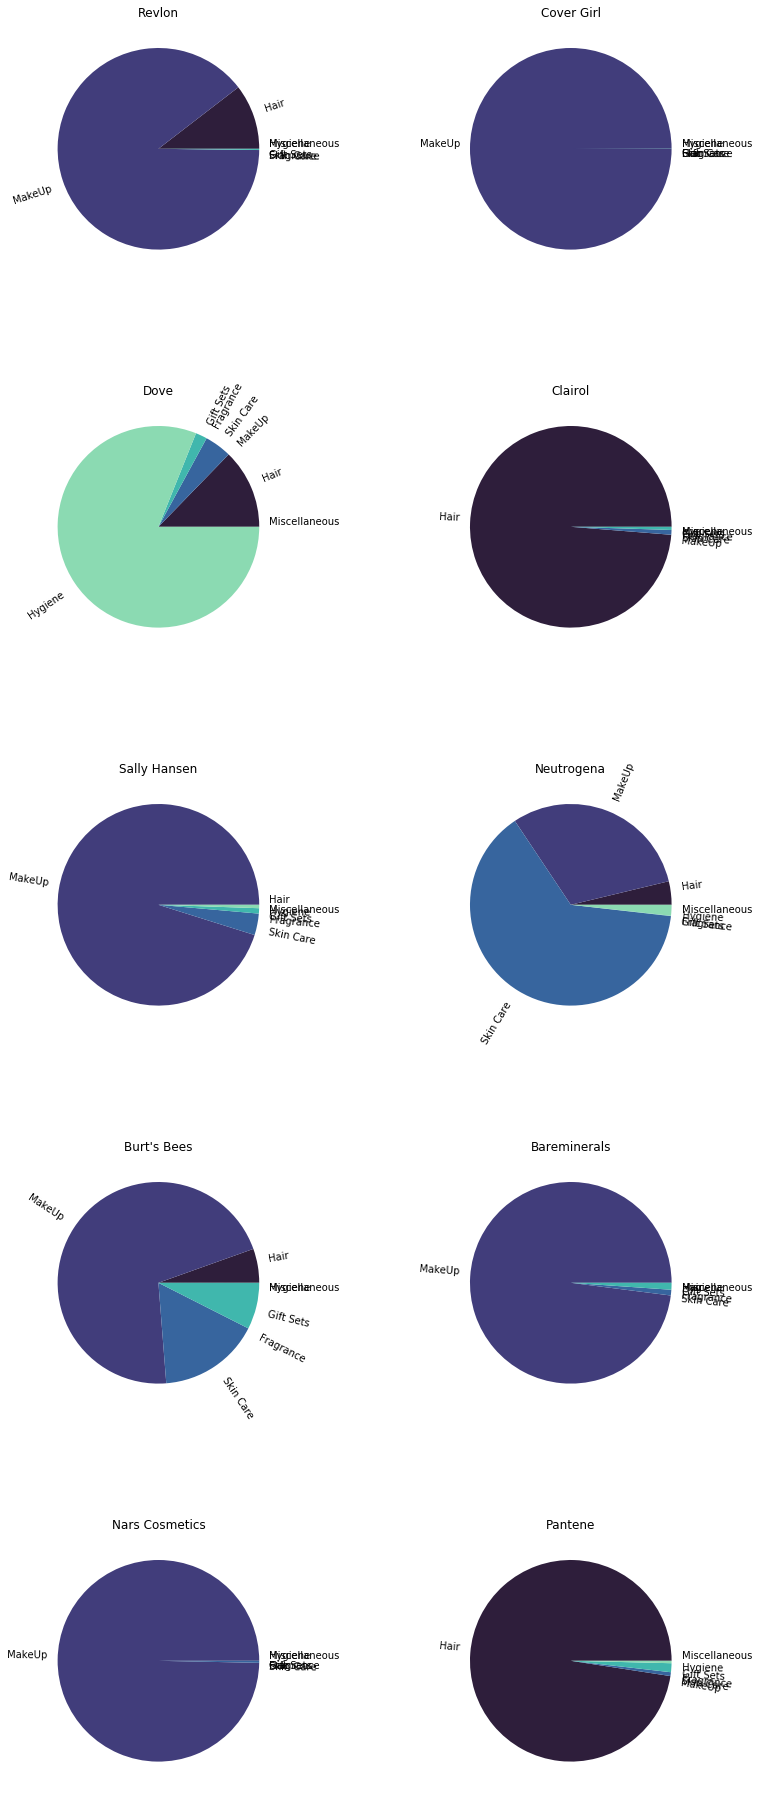

In [34]:
f, ax = plt.subplots(5, 2)
f.set_figheight(35)
f.set_figwidth(15)
plt.gcf().subplots_adjust(left = 0.2, bottom = 0.2, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5)

for i, elt in enumerate(tqdm(top_10_c)):
    vc = cat_pie(elt)
    ax[i//2, i%2].pie(vc.values, labels = vc.index, rotatelabels = 45)
    ax[i//2, i%2].title.set_text(elt)

# 4. Product Deep Dive

## <font color='green'>How can we group product name to achieve a unique product definition?</font>
###### <font color='green'>Insert Answer Here </font>

###### Redundance of product name (grouping by name who have more than 85% of similarity)

In [35]:
def levenshtein(seq1, seq2):
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )
    return (matrix[size_x - 1, size_y - 1])
a = list(df[df[brands] == "L'Oréal Paris"][product_description].unique())
a.sort()
a
a = a[:200]

mat = [[] for elt in range(len(a))]


passed = []
for i in tqdm(range(len(a))):
    for j in range(i+1, min(i+20, len(a))):
        if not(j in passed):
            b = levenshtein(a[i], a[j])
            if b < len(a[i])*0.15:
                mat[i].append((j, b))
                passed.append(j)
                
done = []
for i, elt in enumerate(mat):
    if len(elt)>0:
        if not(i in done):
            print(a[i])
            for elt1 in mat[i]:
                print(a[elt1[0]])
                done.append(elt1[0])
            print('\n')


Colorista Semi Permanent Hair Color - Peach
Colorista Semi Permanent Hair Color Clear


Excellence Creme, 6A Light Ash Brown (Packaging may vary)
Excellence Creme, 6R Light Auburn (Packaging may vary)


Excellence® Créme Permanent Hair Color 5G Medium Golden Brown 2pk
Excellence® Créme Permanent Hair Color 6G Light Golden Brown 2pk


Feria Hair Color, 20 Natural Black (Packaging May Vary)
Feria Hair Color, 21 Bright Black (Packaging May Vary)


Feria Hair Color, 36 Deep Burgundy Brown (Packaging May Vary)
Feria Hair Color, 45 Deep Bronzed Brown (Packaging May Vary)
Feria Hair Color, R37 Deep Burgundy (Packaging May Vary)


Feria Hair Color, 40 Deeply Brown (Packaging May Vary)
Feria Hair Color, 50 Medium Brown (Packaging May Vary)
Feria Hair Color, 56 Auburn Brown (Packaging May Vary)


Feria Hair Color, 58 Medium Golden Brown (Packaging May Vary)
Feria Hair Color, 63 Light Golden Brown (Packaging May Vary)


Feria Midnight Collection Hair Color, M31 Cool Soft Black (Packaging May Var

## <font color='green'>What are the product with the most reviews in the dataset?</font>
###### <font color='green'>Insert Answer Here </font>

###### Top product for top 10 l'oréal brands

In [72]:
# dico_product = {}

# for br in tqdm(top_10_l):
#     dico_product[br] = df[df[brands] == br][product_description].value_counts().iloc[:5].index
    
pd.DataFrame(dico_product)
pd.DataFrame(dico_product)[["L'Oréal Paris", "Maybelline New York", "Garnier"]].style.set_properties(**{'width':'50em', 'text-align':'center'})\
    


## <font color='green'>How do product with the most reviews compare to others in term of ratings?</font>
###### <font color='green'>Insert Answer Here </font>

###### Top 10 product from l'oréal and their avg ratings

Text(0, 0.5, 'Rating average')

C:\Users\gabriel.olympie\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\gabriel.olympie\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0, flags=flags)


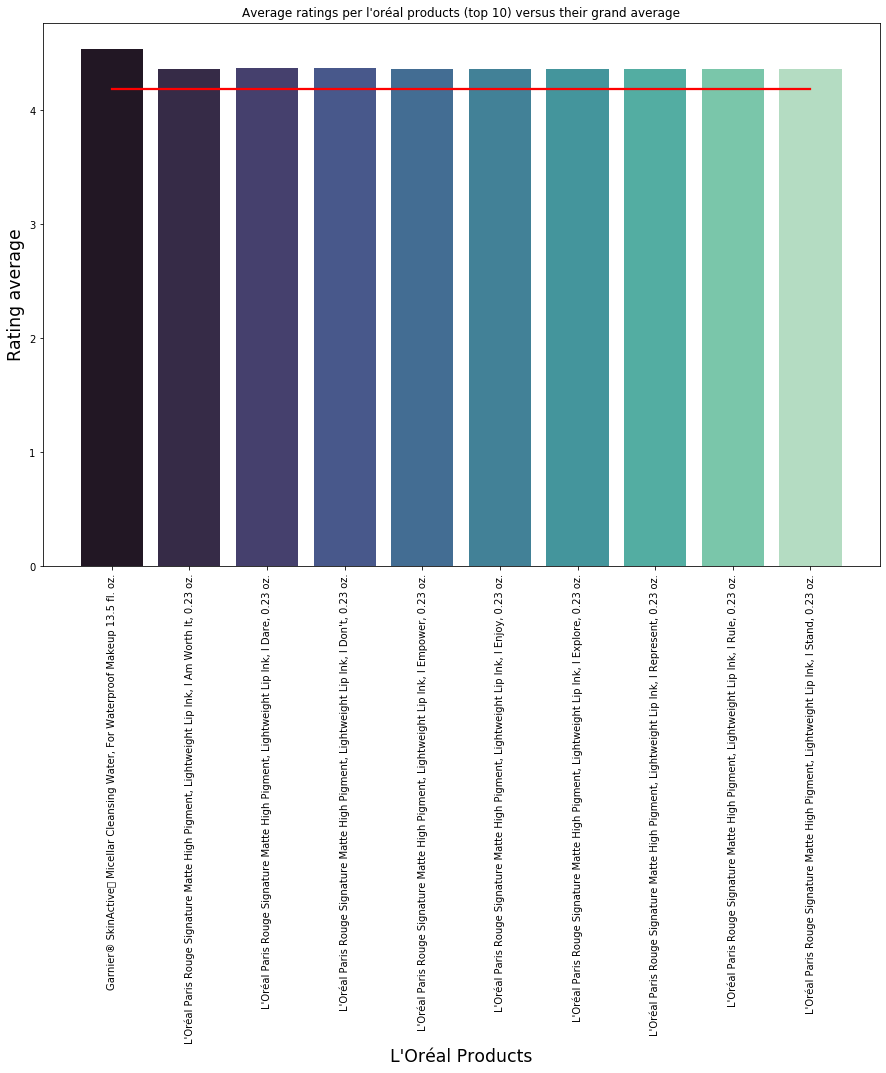

In [37]:
top_10_products_l = df[df[comp] == 0][product_description].value_counts().index[:10]
df.index = df[product_description].values
data = df.loc[top_10_products_l]
data = data[[product_description, ratings]].groupby(product_description).mean()
data[product_description] = data.index
data['avg_rating'] = df[df[comp] == 0][ratings].mean()


plt.figure(figsize = (15, 10))
ax = sns.barplot(x = product_description, y = ratings,data = data, palette = palette(ind))
sns.regplot(x=np.arange(0,data.shape[0]), y=data['avg_rating'], ax=ax, color = 'red')
plt.title("Average ratings per l'oréal products (top 10) versus their grand average")
plt.xticks(rotation=90)
plt.xlabel("L'Oréal Products", fontsize = 'xx-large')
plt.ylabel('Rating average', fontsize = 'xx-large')

Text(0, 0.5, 'Rating average')

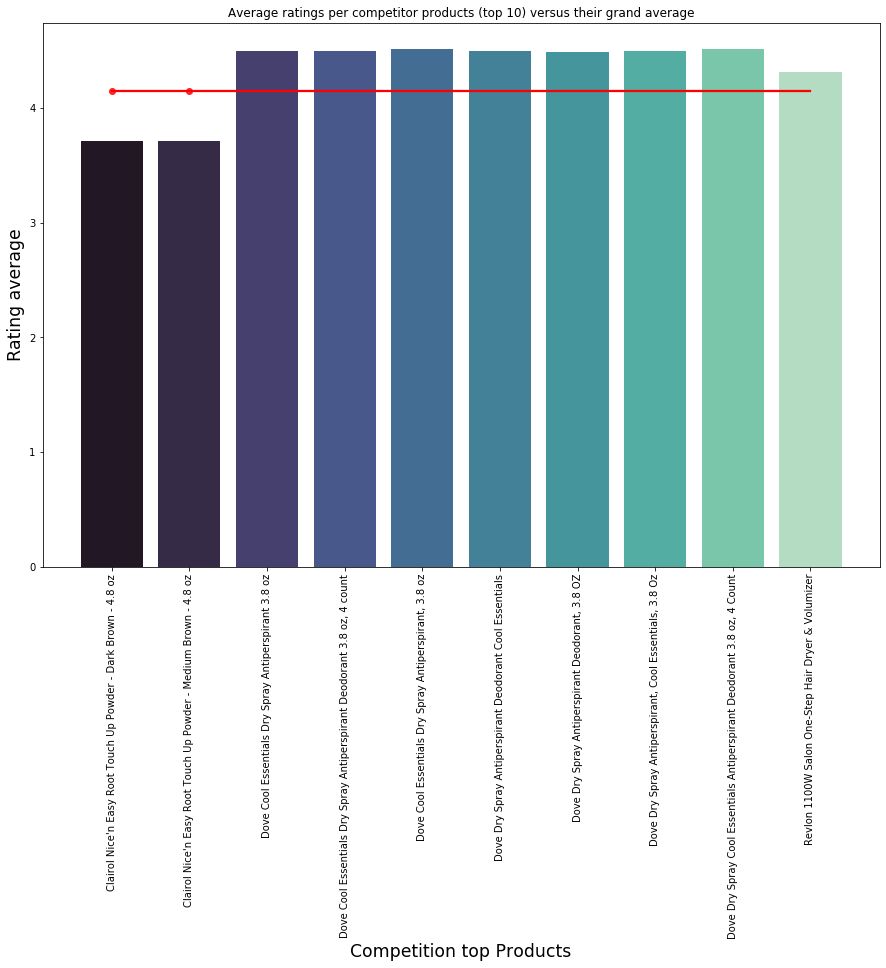

In [38]:
top_10_products_c = df[df[comp] == 1][product_description].value_counts().index[:10]
df.index = df[product_description].values
data = df.loc[top_10_products_c]
data = data[[product_description, ratings]].groupby(product_description).mean()
data[product_description] = data.index
data['avg_rating'] = df[df[comp] == 1][ratings].mean()


plt.figure(figsize = (15, 10))
ax = sns.barplot(x = product_description, y = ratings,data = data, palette = palette(ind))
sns.regplot(x=np.arange(0,data.shape[0]), y=data['avg_rating'], ax=ax, color = 'red')
plt.title("Average ratings per competitor products (top 10) versus their grand average")
plt.xticks(rotation=90)
plt.xlabel("Competition top Products", fontsize = 'xx-large')
plt.ylabel('Rating average', fontsize = 'xx-large')

## <font color='green'>What is the lifetime evolution of a product online in term of number of reviews?</font>
###### <font color='green'>Insert Answer Here </font>

###### Evolution of the number of review per product during time

C:\Users\gabriel.olympie\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabriel.olympie\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\gabriel.olympie\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a co

C:\Users\gabriel.olympie\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\gabriel.olympie\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0, flags=flags)


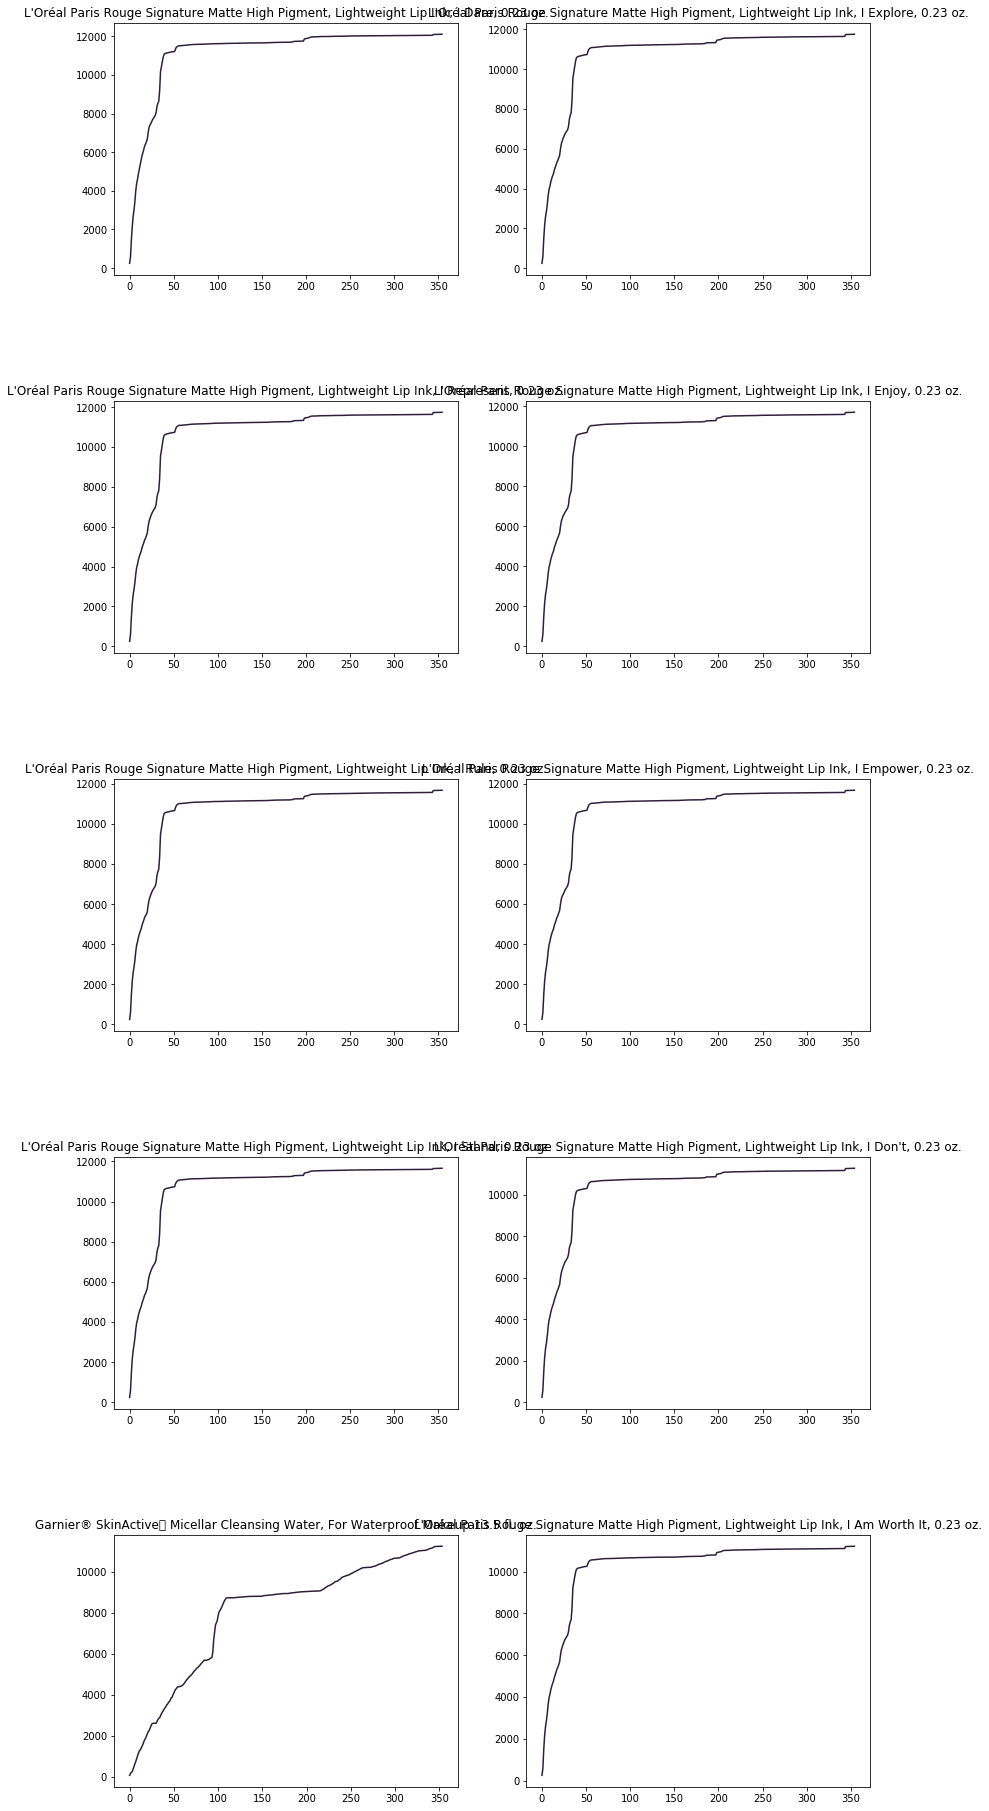

In [39]:
def to_datetime(x):
    return datetime.datetime.strptime(x, '%Y-%m-%d')

def plot_evol(product):
    d = df[df[product_description] == product]
    d['datetime'] = d['date'].apply(to_datetime)
    ref = d['datetime'].min()
    def time_diff(x1):
        return (x1 - ref).days
    d['days_relative'] = d['datetime'].apply(time_diff)
    d = d['days_relative'].value_counts().sort_index().cumsum()
    return d

f, ax = plt.subplots(5, 2)
f.set_figheight(35)
f.set_figwidth(15)
plt.gcf().subplots_adjust(left = 0.2, bottom = 0.2, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5)

for i, elt in enumerate(tqdm(top_10_products_l)):
    vc = plot_evol(elt)
    ax[i//2, i%2].plot(vc.index, vc.values)
    ax[i//2, i%2].title.set_text(elt)

In [ ]:
# f, ax = plt.subplots(5, 2)
# f.set_figheight(35)
# f.set_figwidth(15)
# plt.gcf().subplots_adjust(left = 0.2, bottom = 0.2, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5)


# for i, elt in enumerate(tqdm(top_10_products_l)):
#     vc = plot_evol(elt)
#     ax[i//2, i%2].plot(vc.index, vc.values)
#     ax[i//2, i%2].title.set_text(elt)

## <font color='green'>What is the distribution of ratings?</font>
###### <font color='green'>Insert Answer Here </font>

# 5. Ratings Deep Dive

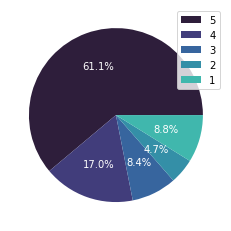

In [40]:
vc = df[ratings].value_counts().sort_index(ascending = False)
plt.pie(vc.values, labels = vc.index, rotatelabels = 0, autopct='%1.1f%%', textprops=dict(color="w"))
plt.legend(vc.index)

###### Compare ratings from the dataset to current ratings on the site

In [41]:
a = df[df[retailer] == 'WALMART']['url'].unique()[1]

In [42]:
def reform_image(img): 
    image1 = np.zeros((img.shape[0], img.shape[1], img.shape[2])).astype(int)
    image1[:,:, 0] = img[:,:, 2]
    image1[:,:, 1] = img[:,:, 1]
    image1[:,:, 2] = img[:,:, 0]
    return image1

def get_current_star(walmart_url):
    response = requests.get(walmart_url)
    soup = bs4.BeautifulSoup(response.text, 'html.parser')
    rate = soup.find_all("span", {"itemprop":"ratingValue"})
    rate = str(rate[0])
    return float(rate.split('>')[1].split('<')[0])


def get_img(walmart_url):
    response = requests.get(walmart_url)
    soup = bs4.BeautifulSoup(response.text, 'html.parser')
    rate = soup.find_all("img", {"loading":"lazy"})
    img = rate[1]['src']
    url1 = 'http:'+img 
    data = BytesIO(urllib.request.urlopen(url1).read())
    image = np.asarray(bytearray(data.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = reform_image(image)
    return image

## <font color='green'>How do the ratings from the provider compare to the ratings available online?</font>
###### <font color='green'>Insert Answer Here </font>

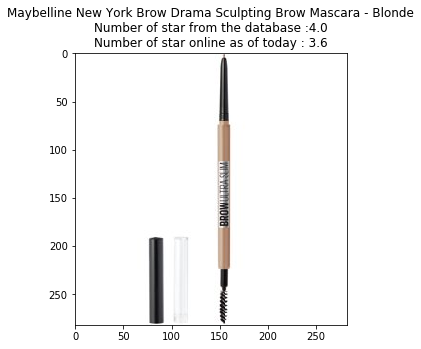

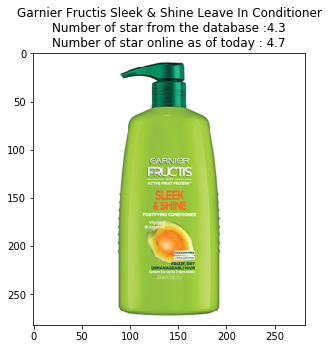

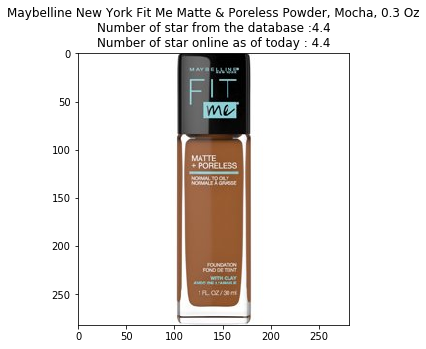

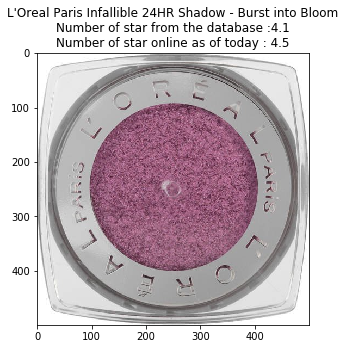

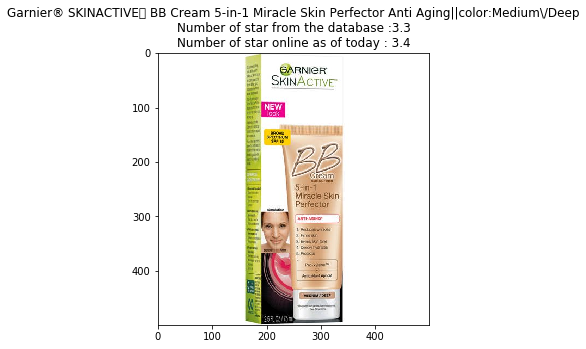

In [43]:

test_list = np.random.choice(list(df[df[retailer] == 'WALMART']['upc1'].unique()) , size = 20)


count = 0
i = 0
while count < 5:
    elt = test_list[i]
    i+=1
    try:
        
        df1 = df[df['upc1'] == elt]
        product = df1.iloc[0][product_description]
        rates = df1[ratings].mean()
        urls = df1[url].value_counts().index[0]
        web_rates = get_current_star(urls)
        image = get_img(urls)
        count +=1
        plt.figure(figsize = (10, 5))
        plt.imshow(image)
        plt.title(product+ '\n' + 'Number of star from the database :' + str(round(rates, 1)) + '\n'+ 'Number of star online as of today : '+str(web_rates))
        
    except:
        1
    
    

## <font color='green'>How does the rating distribution evolve over time?</font>
###### <font color='green'>Insert Answer Here </font>

###### Ratings evolutions

In [44]:
one_hot_ratings = pd.get_dummies(df[ratings])

for i in range(1, 6):
    df[i] = one_hot_ratings[i]

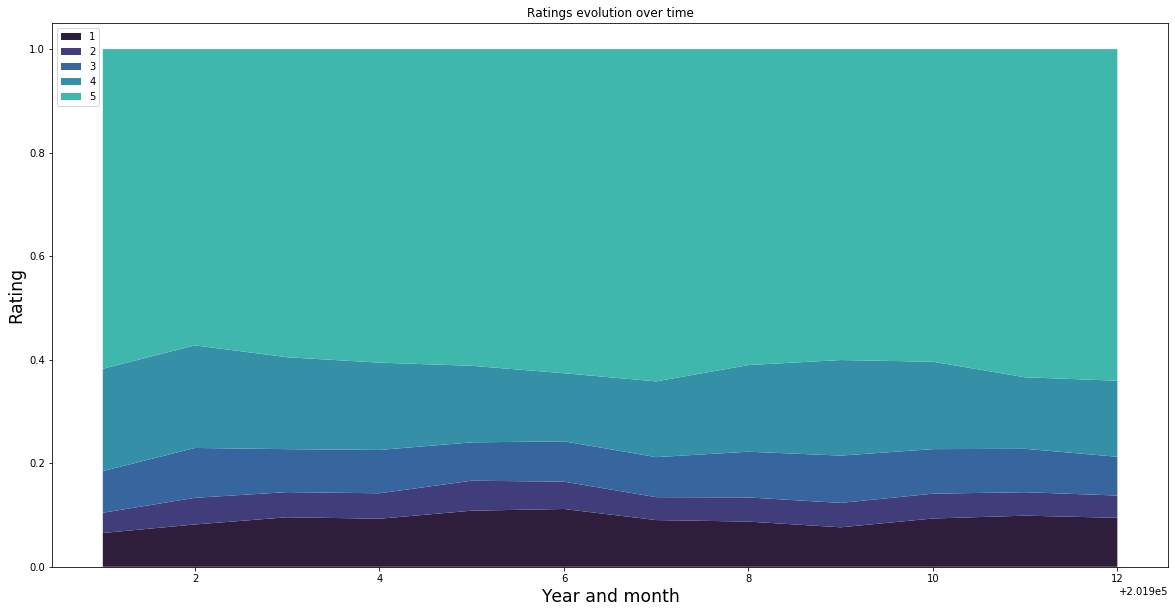

In [45]:
time_data = df[['annmonth', 1, 2, 3, 4, 5]].groupby('annmonth').sum().sort_index()

x = time_data.index
y = time_data.values.T / time_data.values.sum(axis = 1)

plt.figure(figsize = (20, 10))
plt.stackplot(x,y, labels=time_data.columns)
plt.title('Ratings evolution over time')
plt.xlabel('Year and month', fontsize = 'xx-large')
plt.ylabel('Rating', fontsize = 'xx-large')
plt.legend(loc='upper left')


## <font color='green'>How does the rating distribution evolve over time for each retailer?</font>
###### <font color='green'>Insert Answer Here </font>

###### Ratings evol per retailers

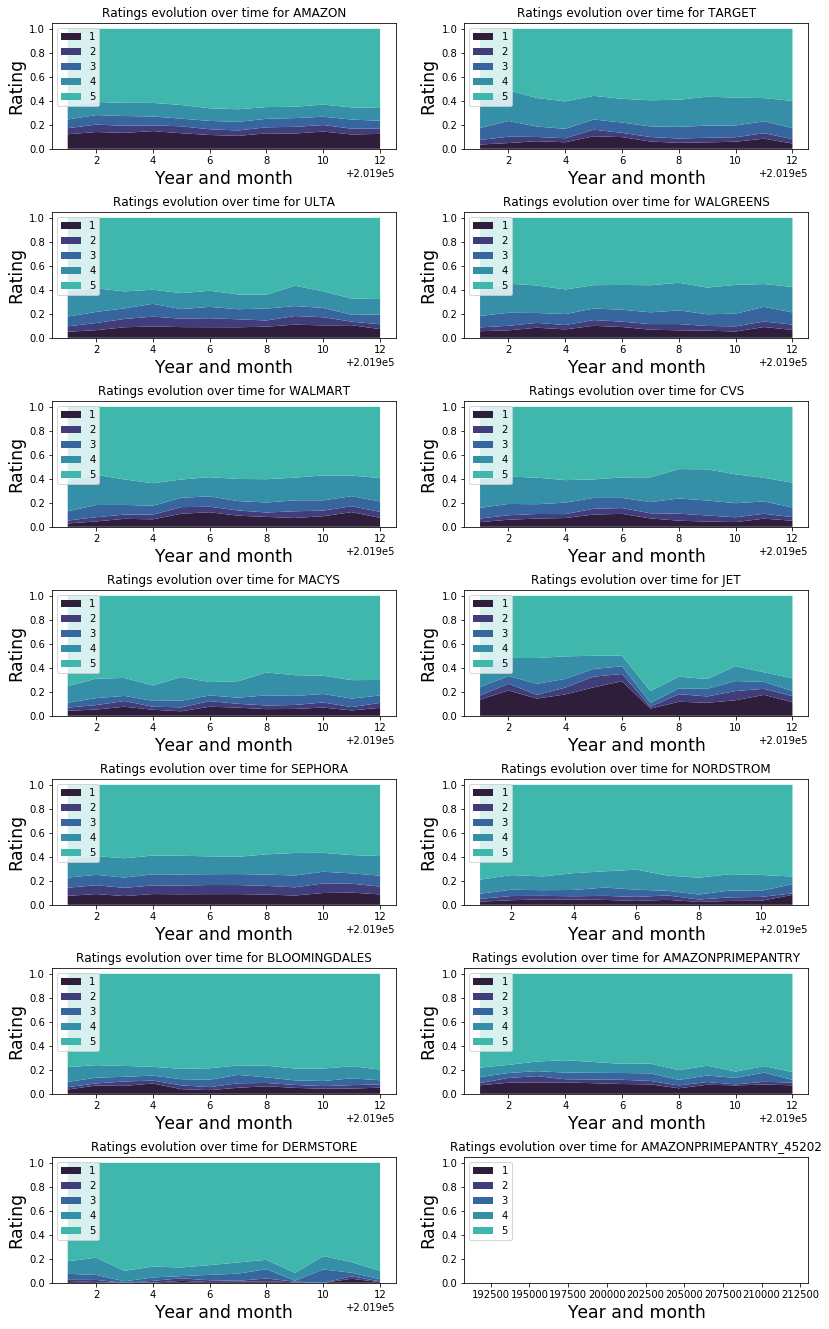

In [46]:
def rateplot(ret):
    d = df[df[retailer] == ret]
    time_data = d[['annmonth', 1, 2, 3, 4, 5]].groupby('annmonth').sum().sort_index()
    x = time_data.index
    y = time_data.values.T / time_data.values.sum(axis = 1)
    return x, y

f, ax = plt.subplots(7, 2)
f.set_figheight(25)
f.set_figwidth(15)
plt.gcf().subplots_adjust(left = 0.2, bottom = 0.2, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5)
# y_lim = df[retailer].value_counts().values.max()*0.8

for i, elt in enumerate(tqdm(df[retailer].value_counts().index)):
    x, y = rateplot(elt)
    ax[i//2, i%2].stackplot(x,y, labels=time_data.columns)
    ax[i//2, i%2].set_title('Ratings evolution over time for '+elt)
    ax[i//2, i%2].set_xlabel('Year and month', fontsize = 'xx-large')
    ax[i//2, i%2].set_ylabel('Rating', fontsize = 'xx-large')
    ax[i//2, i%2].legend(loc='upper left')

## <font color='green'>How does the rating distribution evolve over time for each category?</font>
###### <font color='green'>Insert Answer Here </font>

###### Rating evol per category

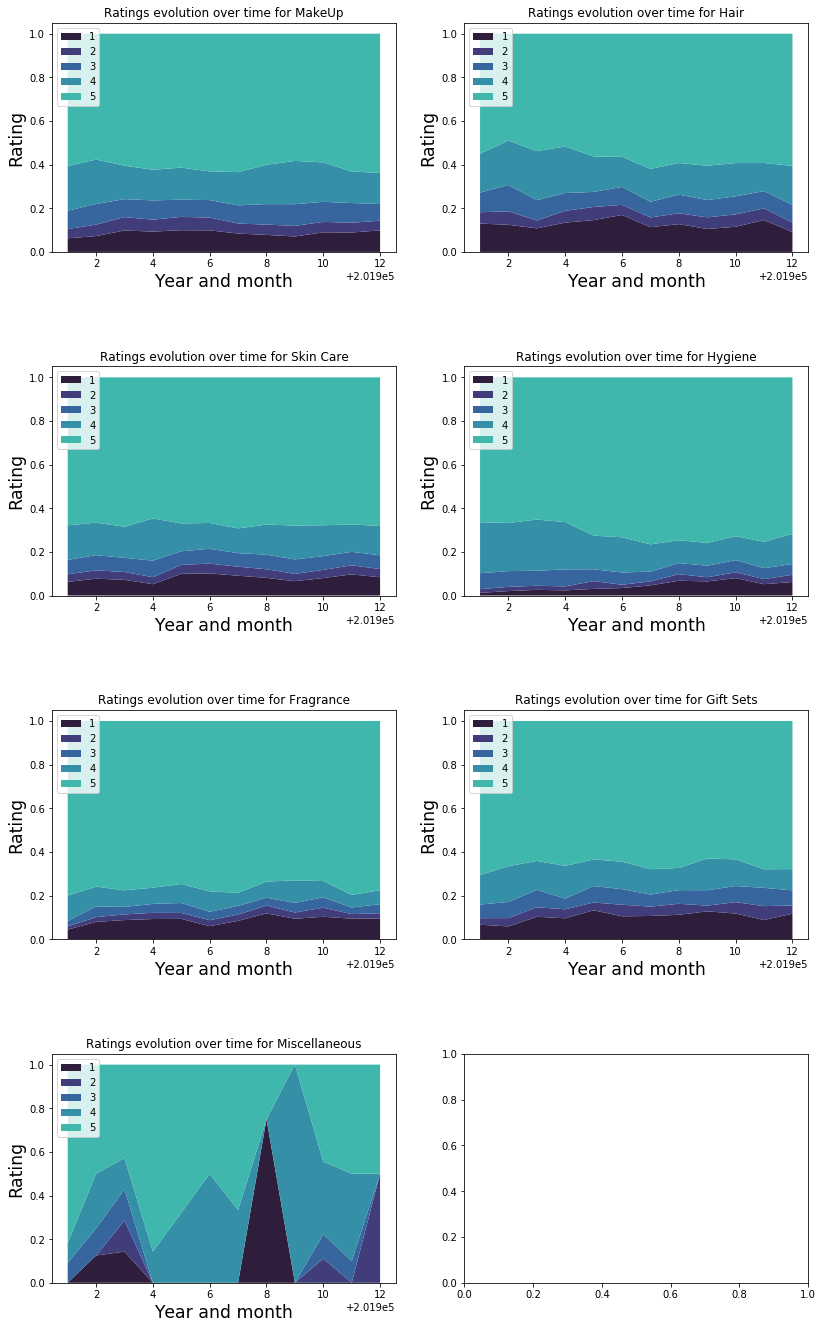

In [47]:
def rateplot(cat):
    d = df[df[category] == cat]
    time_data = d[['annmonth', 1, 2, 3, 4, 5]].groupby('annmonth').sum().sort_index()
    x = time_data.index
    y = time_data.values.T / time_data.values.sum(axis = 1)
    return x, y

f, ax = plt.subplots(4, 2)
f.set_figheight(25)
f.set_figwidth(15)
plt.gcf().subplots_adjust(left = 0.2, bottom = 0.2, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5)
# y_lim = df[retailer].value_counts().values.max()*0.8

for i, elt in enumerate(tqdm(df[category].value_counts().index)):
    x, y = rateplot(elt)
    ax[i//2, i%2].stackplot(x,y, labels=time_data.columns)
    ax[i//2, i%2].set_title('Ratings evolution over time for '+elt)
    ax[i//2, i%2].set_xlabel('Year and month', fontsize = 'xx-large')
    ax[i//2, i%2].set_ylabel('Rating', fontsize = 'xx-large')
    ax[i//2, i%2].legend(loc='upper left')